In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve
from scipy.linalg import det
from cycler import cycler

## Linearised stability analysis

### The base state

The assembled, base-state solution is given by


\begin{alignat}{3}
     \label{eq:rxflow-base-state-solution}
    \usat\zeroth &= \left(1+\dpro\right)\e^{\rpro z} - \dpro
    &&\approx 1 + \left(1+\dpro\right) \rpro z,\\
    -\cmppres\zeroth &= \usat\zeroth+\dpro &&\approx
    \left(1+\dpro\right) \left(1 + \rpro z\right),\\
    \por\zeroth &= \left[\frac{\usat\zeroth}
      {1+\stiff\rpro\left(\usat\zeroth+\dpro\right)}\right]^{1/\permexp}
    &&\approx  \cbasestate^{-1}\left[1 + 
      \left(1+\dpro\right) \rpro z/n\right].\\
    w\zeroth &= \left[\frac{1+\stiff\rpro\left(\usat\zeroth+\dpro\right)}
      {\left(\usat\zeroth\right)^{1-\permexp}}\right]^{1/\permexp} 
    &&\approx \cbasestate\left[1 + \left(1+\dpro\right)(1-1/n) \rpro z\right].
\end{alignat}


The base-state solution (1)-(4), are plotted below for two values of $\rpro$. Thick lines are the full solution and narrow lines are the linear approximation. In each case, $\stiff=1$, $\dpro=1$ and $\permexp=3$. The values of $\por\zeroth$ (panel __(c)__) and $w\zeroth$ (panel __(d)__) at $z=0$ are given by $\cbasestate^{-1}$ and $\cbasestate$, respectively.

In [2]:
n = 3.0
G = 1.0
M = np.asarray([0.01, 0.1])
S = 1.0
H = 1.0
z = np.linspace(0.0, H, 1000)

F = np.power([1.0 + S*m*(1+G) for m in M], 1/n)
chi = np.asarray([(1.+G)*np.exp(m*z) - G for m in M])
cmp = -(chi + G)
phi = np.power([chij/(1.0 - S*m*cmpj) for chij, m, cmpj in zip(chi, M, cmp)], 1.0/n)
w = chi/phi
cmpl = -(1.0+G) * np.asarray([1.0 + m*z for m in M])
chil = 1.0 + np.asarray([m*(1+G)*z for m in M])
phil = np.asarray([1.0/Fj * (1.0 + m*(1.0 + G)/n*z) for Fj, m in zip(F, M)])
wl = np.asarray([Fj*(1.0 + m*(1.0+G)*(1.0-1.0/n)*z) for Fj, m in zip(F, M)])

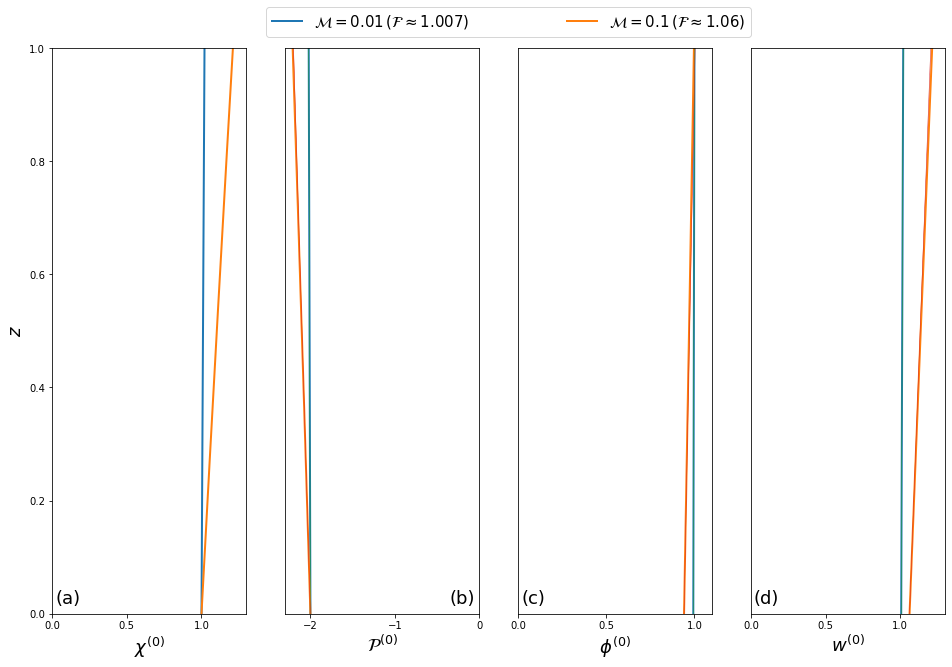

In [3]:
f, ax = plt.subplots(1, 4)
zoom = 2.0
f.set_size_inches(8.0 * zoom, 5.2 * zoom)
f.set_facecolor('w')

plt.rc('axes', prop_cycle=(cycler(color=['k', 'k', 'k', 'k']) + cycler(linestyle=['-', '--', ':', '-.'])))

lines = ax[0].plot(chi.transpose(), z, linewidth=2.0)
ax[0].set_xlabel(r'$\chi^{(0)}$', fontsize=18)
ax[0].set_xlim(0.0, 1.3)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylabel('$z$', fontsize=18)
ax[0].set_ylim(0.0, 1.0)
ax[0].text(0.02, 0.01, '(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
plt.legend(handles=(lines[0], lines[1]), 
           labels=(r'$\mathcal{M}=0.01\,(\mathcal{F}\approx1.007)$', r'$\mathcal{M}=0.1\,(\mathcal{F}\approx1.06)$'),
           fontsize=15, bbox_to_anchor=(-2.5, 1.02, 2.5, .2),
           loc='lower right', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(cmp.transpose(), z, linewidth=2.0)
ax[1].plot(cmpl.transpose(), z, linewidth=0.5)
ax[1].set_xlabel(r'$\mathcal{P}^{(0)}$', fontsize=18)
ax[1].set_xlim(-2.3, 0.0)
ax[1].set_xticks((-2.0, -1.0, 0.0))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].text(-0.35, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[2].plot(phi.transpose(), z, linewidth=2)
ax[2].plot(phil.transpose(), z, linewidth=0.5)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi^{(0)}$', fontsize=18)
ax[2].set_xlim(0.0, 1.1)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].text(0.02, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[3].plot(w.transpose(), z, linewidth=2)
ax[3].plot(wl.transpose(), z, linewidth=0.5)
ax[3].set_xlabel(r'$w^{(0)}$', fontsize=18)
ax[3].set_yticks(())
ax[3].set_xlim(0.0, 1.3)
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].text(0.02, 0.01, '(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

plt.show()

### The growth rate of perturbations

The perturbation to the base-state compaction pressure is an ansatz with unknown $k,m_j,\sigma$, constructed from
eigenfunctions of the differential operators, given by
\begin{equation}
  \label{eq:rxflow-cbs-ansatz}
  \cmppres\first(x,z,t) = \text{Re}\sum_{j=1}^3 A_j\exp\left(i\wavenumber x +
    m_jz + \sigma t\right),
\end{equation}
where $\text{Re}$ means taking only the real part of the complex expression. Equation \eqref{eq:rxflow-cbs-ansatz} satisfies a linear, partial differential equation that is third order in the $z$ direction

\begin{equation}
  \label{eq:rxflow-cbs-por}
  \left[ \partial_t + \frac{\partial_{tz}}{\Da} 
    -\permexp - \frac{\partial_{txx}}{\Da\Pe}\right]
  \stiff\delsq\cmppres\first = \left[1 +
    \left(\frac{1}{\Da} - \stiff\right)\partial_z- 
    \frac{\partial_{xx}}{\Da\Pe}\right]
  \permexp\partial_z\cmppres\first.
\end{equation}

In [4]:
class PAR:
    def __init__(self, F_=1.0, n_=3, S_=1.0, Da_=1000.0, Pe_=100.0, M_=0.01, G_=1,
                 bc_=2, nz_=1000, tol_=1e-5, plot_=False, step_=0.01, largeDa_=False):
        self.F = F_  # base - state parameter - force to be constant
        self.n = n_  # permeability exponent
        self.S = S_  # rigidity parameter
        self.Da = Da_  # Damkohler number
        self.Pe = Pe_  # Peclet number
        self.M = M_  # solubility gradient parameter
        self.G = G_  # decompression melting parameter
        self.bc_type = bc_  # boundary condition type -- 1) P(1)=0; 2) P'(1)=0
        self.nz = nz_  # number of points for eigenfunction
        self.tol = tol_  # tolerance
        self.plot = plot_  # plot eigenfunction
        self.step = step_  # stepsize in log10(k) - sigma space
        self.largeDa = largeDa_

        
class EIG:
    def __init__(self, p_=0.0, phi_=0.0):
        self.P = p_
        self.phi = phi_


class SA:
    def __init__(self, k_=0.0, sigma_=0.0, m_=0.0, flag_=False):
        self.k = k_
        self.sigma = sigma_
        self.m = m_
        self.eig = EIG()
        self.flag = flag_


class DC:
    def __init__(self, s_=0.0, k_=0.0, m_=0.0):
        self.s = s_
        self.k = k_
        self.m = m_

In [5]:
def zero_by_sigma(sig, k, par):
    m = np.roots(characteristic_polynomial(k, sig, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sig, par))
        residual = np.real((1.0 - 1.j) * detM)
    return residual

In [6]:
def zero_by_wavenumber(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sigma, par))
        residual = np.real((1 - 1j) * detM)
    return residual

Substituting \eqref{eq:rxflow-cbs-ansatz} into \eqref{eq:rxflow-cbs-por} we obtain the characteristic polynomial

\begin{equation}
  \label{eq:characteristic-poly-cbs}
  \frac{\sigma}{\Da}m^3 + 
  \left(\sigma\Kk - \frac{n}{\Da\stiff}\right)m^2
  - \left(\frac{n\Kk}{\stiff} +
    \frac{\sigma }{\Da}k^2\right)m + 
  \left(\permexp - \sigma\Kk\right)k^2 = 0,
\end{equation}

where $\Kk = 1 + k^2/\left(\Da\Pe\right)$. For a given value of $\sigma$ (which is, in fact, an unknown), equation \eqref{eq:characteristic-poly-cbs} is solved to obtain the roots $m_j$.

The function `characteristic_polynomial` below evaluates the coefficients of the characteristic polynomial.

In [7]:
def characteristic_polynomial(k, sig, par):
    K = k ** 2 / par.Da / par.Pe / par.F + 1.0
    p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic
                    sig * K - par.n * np.power(par.F, 1 + par.n) / par.Da / par.S,  # quadratic
                    -(par.n * np.power(par.F, 1 + par.n) * K / par.S + sig * k ** 2 / par.Da),  # linear
                    k ** 2 * (par.n * np.power(par.F, 1 - par.n) - sig * K)])  # constant
    return p.reshape(p.shape[0])

In [8]:
def boundary_condition_matrix(k, m, sig, par):
    if par.bc_type == 1:
        M = np.asarray([[1.0, mi, np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 2:
        M = np.asarray([[1.0, mi, mi * np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 3:
        q = sig * par.S / par.n
        M = np.asarray([[q * mi - 1.0, q * mi ** 2 - mi - q * k ** 2, mi * np.exp(mi)] for mi in m]).transpose()
    else:
        q = k ** 2 * par.Da / par.DaPe
        M = np.asarray([[1.0 - par.S * mi, mi ** 2 + q * mi, mi * np.exp(mi)] for mi in m]).transpose()
    return M

In [9]:
def form_eigenfunction(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    z = np.linspace(0.0, 1.0, par.nz)
    eig = EIG()
    if par.largeDa:
        eig.P = np.exp(np.real(m[0]) * z) * np.sin(np.imag(m[0]) * z)
        eig.P = eig.P / np.max(np.abs(eig.P))
        Q = (m[0] ** 2 - k ** 2) * eig.P
        eig.phi = np.power(par.F, -1.0 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    else:
        M = boundary_condition_matrix(k, m, sigma, par)
        subM = M[:, 1::]
        b = -M[:, 0]
        A = np.concatenate((np.asarray([1.0+0.j]), np.linalg.lstsq(subM, b, rcond=None)[0]))
        eig.P = np.sum(np.asarray([Aj * np.exp(mj * z) for Aj, mj in zip(A, m)]).transpose(), axis=1)
        Q = np.sum(np.asarray([(mj ** 2 - k ** 2) * Aj * np.exp(mj * z) 
                               for Aj, mj in zip(A, m)]).transpose(), axis=1)
        eig.phi = np.power(par.F, -1 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    return eig

Function `reactive_flow_solve_dispersion` below implements a recipe for obtaining solutions: for a given set of parameters $\permexp$, $\stiff$, $\Da$, $\Pe$ and a chosen horizontal wavenumber $k$, form an initial guess of $\sigma$. Using this guess, obtain the three roots of the characteristic polynomial~\eqref{eq:characteristic-poly-cbs}. Use these roots to form the residual $r$.  If $r$ is below a specified tolerance, accept the guess of $\sigma$ as a solution; otherwise, improve the guess of $\sigma$ (using, for example, $\infd r/\infd\sigma$ and Newton's method) and again form the residual. Repeat this until the tolerance has been satisfied. Then, with the converged value for $\sigma$, obtain the roots $m_j$, take $A_1=1$, and solve equation \eqref{eq:rxflow_cbs_matrix_eqn} for $A_2$ and $A_3$. Use the values of $A_j$ to form the eigenfunction $\cmppres\first$ at $t=0$.

In [10]:
def reactive_flow_solve_dispersion(k_guess, sigma_guess, par):
    # input parameters:
    #   k -- horizontal wavenumber (required)
    #   sigma_guess -- guess at the eigenvalue (optional)
    #   par -- parameter structure (optional)

    sa = SA()

    if type(k_guess) is not np.ndarray:
        # solving for growthrate sigma at a fixed value of wavenumber k
        solve_for_sigma = True
        sa.k = k_guess
        if sigma_guess is None:
            sigma_guess = np.logspace(-1.0, 1.0, 100)
        if type(sigma_guess) is not np.ndarray:
            sigma_guess = np.asarray([sigma_guess])
    else:
        # solving for wavenumber k at a fixed value of growthrate sigma
        solve_for_sigma = False
        sa.sigma = sigma_guess if type(sigma_guess) is not np.ndarray else sigma_guess[0]

    if par.F is None:
        par.F = np.power(1.0 + par.S * par.M * (1.0 + par.G), 1.0 / par.n)

    sigma = np.zeros_like(sigma_guess)
    k = np.zeros_like(k_guess)
    if solve_for_sigma:
        # solve eigenvalue problem to find growth rate of fastest-growing mode
        res = np.zeros_like(sigma_guess)
        exitflag = np.zeros_like(sigma_guess)
        converged = np.zeros_like(sigma_guess)
        problem_sigma = lambda s: zero_by_sigma(s, sa.k, par)
        for j in range(len(sigma_guess)):
            [sigma[j], infodict, exitflag[j], _] = fsolve(problem_sigma, sigma_guess[j], 
                                                          full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 and np.abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(sa.k, sigma[j], par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(sa.k, sigma[j], par)
                # plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))
    else:
        # solve eigenvalue problem to find wavenumber of mode
        problem_wavenumber = lambda s: zero_by_wavenumber(s, sa.sigma, par)
        res = np.zeros_like(k_guess)
        exitflag = np.zeros_like(k_guess)
        converged = np.zeros_like(k_guess)
        for j in range(len(k_guess)):
            [k[j], infodict, exitflag[j], _] = fsolve(problem_wavenumber, k_guess[j], full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 or abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(k[j], sa.sigma, par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(k[j], sa.sigma, par)
                plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))

        # [converged', exitflag', log10(abs(res'))];
    none_converged = not np.sum(converged)

    # handle failure to find solution
    if none_converged:
        print(f'FAILURE: no solution found for k={k_guess}')
        sa.sigma = np.nan
        sa.k = np.nan
        sa.m = [np.nan, np.nan, np.nan]
        sa.eig.P = np.nan
        sa.flag = False
        return sa
    elif solve_for_sigma:
        sa.sigma = np.amax(sigma[converged != 0])
    else:
        sa.k = np.amax(k[converged != 0])

    sa.m = np.roots(characteristic_polynomial(sa.k, sa.sigma, par))

    # form and check eigenfunction
    sa.eig = form_eigenfunction(sa.k, sa.sigma, par)
    gP = np.gradient(sa.eig.P)

    if (gP < 0).any() and par.bc_type != 1:
        sa.flag = False
        print(f'FAILURE: non-monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')
    else:
        sa.flag = True
        print(f'SUCCESS: monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')

    if par.plot:
        plt.plot(np.linspace(0, 1, par.nz), np.real(sa.eig.P), linewidth=2)

    return sa

In [11]:
def taylor_series_extension(n, x, y, step, init_Lks):
    if n == 0:
        xguess = init_Lks[0]
        yguess = init_Lks[1]
    elif n == 1:
        xguess = x[0]-step
        yguess = y[0]
    elif n == 2:
        d = np.asarray([x[1]-x[0], y[1]-y[0]])
        d = d/np.sqrt(np.sum(d**2))
        xguess = x[-1] + d[0]*step
        yguess = y[-1] + d[1]*step
    else:
        da = np.asarray([x[-1]-x[-2], y[-1]-y[-2]])
        db = np.asarray([x[-2]-x[-3], y[-2]-y[-3]])
        D = 0.5*(np.sqrt(np.sum(da**2)) + np.sqrt(np.sum(db**2)))
        da = da/np.sqrt(np.sum(da**2))
        db = db/np.sqrt(np.sum(db**2))
        d2 = (da - db)/D
        xguess = x[-1] + da[0]*step + 0.5*d2[0]*step**2
        yguess = y[-1] + da[1]*step + 0.5*d2[1]*step**2

    if np.isinf(xguess) or np.isnan(xguess):
        xguess = x[-1]
    if np.isinf(yguess) or np.isnan(yguess):
        yguess = y[-1]

    return xguess, yguess

In [12]:
def reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks):
    n = 0  # can n be zero?
    Lk = np.full((1, ), np.inf)  # dictionaries
    s = np.full((1, ), np.inf)
    m = m = np.full((1, 2), np.inf + 0.j, dtype=np.complex) if par.largeDa \
        else np.full((1, 3), np.inf + 0.j, dtype=np.complex)

    for j in [0, 1]:
        fails = 0
        while n < 1_000_000:
            Lk_guess, s_guess = taylor_series_extension(n, Lk, s, par.step, init_Lks)
            if Lk_guess <= Lkbounds[0] or Lk_guess >= Lkbounds[1]:
                break
            if s_guess <= sbounds[0] or s_guess >= sbounds[1]:
                break

            if n == 0:
                s_guess = np.linspace(0.1, par.n, 30)
            elif fails <= 1:
                print(f'Iteration {n}: searching for solution at k={np.power(10, Lk_guess)}')
                s_guess = s_guess * np.linspace(0.99, 1.01, 16)
            elif fails == 2:
                print(f'Iteration {n}: searching for solution at sigma={s_guess}')
                Lk_guess = Lk_guess * np.linspace(0.99, 1.01, 16)
            else:
                break

            sa = reactive_flow_solve_dispersion(np.power(10., Lk_guess), s_guess, par)

            if sa.flag:
                # found lowest mode; prepare for next iteration
                if n == 0:
                    Lk[n] = np.log10(sa.k)
                    s[n] = sa.sigma
                    m[n] = sa.m
                else:
                    Lk = np.concatenate((Lk, np.asarray([np.log10(sa.k)])))
                    s = np.concatenate((s, np.asarray([sa.sigma])))
                    m = np.concatenate((m, np.asarray([sa.m])))
                n = n + 1
                fails = 0
            else:
                # found higher mode; retry
                fails = fails + 1

        if j == 0:
            s = np.flip(s)
            Lk = np.flip(Lk)
            m = np.flipud(m)

    return DC(s, np.power(10., Lk), m)

In [13]:
par = PAR()

Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])

DC_ref = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)
iref = np.argmax(DC_ref.s)

dpar = par
dpar.Da = 10.0
DC_a = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)
dpar.Da = 100.0
DC_b = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004
SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257
SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083
SUCCESS: 

SUCCESS: monotonic eigenfunction for k=3.0190647462210927, sigma=2.0364314656429285
Iteration 60: searching for solution at k=3.000457893037922
SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945
SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.911091625927486
SUCCESS: monotonic eigenfunction for k=2.911091625927486, sigma=1.9783286475808557
Iteration 66: searching for solution at k=2.89391533384175

SUCCESS: monotonic eigenfunction for k=2.2367630800625897, sigma=1.469595846875035
Iteration 118: searching for solution at k=2.2270825745299168
SUCCESS: monotonic eigenfunction for k=2.2270825745299168, sigma=1.4597465185876184
Iteration 119: searching for solution at k=2.21749729193307
SUCCESS: monotonic eigenfunction for k=2.21749729193307, sigma=1.449895104331992
Iteration 120: searching for solution at k=2.2080062322000464
SUCCESS: monotonic eigenfunction for k=2.2080062322000464, sigma=1.4400416077527871
Iteration 121: searching for solution at k=2.198608429974093
SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.189302954195696
SUCCESS: monotonic eigenfunction for k=2.189302954195696, sigma=1.4203283756343439
Iteration 123: searching for solution at k=2.180088907719179
SUCCESS: monotonic eigenfunction for k=2.180088907719179, sigma=1.4104686407760079
Iteration 124: searching for solution at k=2.1709654

SUCCESS: monotonic eigenfunction for k=1.811408959431238, sigma=0.8842013509494759
Iteration 177: searching for solution at k=1.8067676381968854
SUCCESS: monotonic eigenfunction for k=1.8067676381968854, sigma=0.8741634635426274
Iteration 178: searching for solution at k=1.8022273167477263
SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=1.789231921433876
SUCCESS: monotonic eigenfunction for k=1.789231921433876, sigma=0.8339327226432995
Iteration 182: searching for solution at k=1.7851158060094738
SUCCESS: monotonic eigenfunction for k=1.7851158060094738, sigma=0.8238525376988776
Iteration 183: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.8265669797070296, sigma=0.34970684824880616
Iteration 231: searching for solution at k=1.8370483397434019
SUCCESS: monotonic eigenfunction for k=1.8370483397434019, sigma=0.34035854602811827
Iteration 232: searching for solution at k=1.8483146513564606
SUCCESS: monotonic eigenfunction for k=1.8483146513564606, sigma=0.33104862994809753
Iteration 233: searching for solution at k=1.860409093908101
SUCCESS: monotonic eigenfunction for k=1.860409093908101, sigma=0.3217827325364915
Iteration 234: searching for solution at k=1.8733767541244355
SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution at k=1.8872645342547272
SUCCESS: monotonic eigenfunction for k=1.8872645342547272, sigma=0.3034075073761858
Iteration 236: searching for solution at k=1.9021210169942402
SUCCESS: monotonic eigenfunction for k=1.9021210169942402, sigma=0.2943114912123439
Iteration 237: searching for solution a

SUCCESS: monotonic eigenfunction for k=3.2394471633702038, sigma=0.07658126376116571
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at k=3.310143618198963
FAILURE: no solution found for k=3.310143618198963
Iteration 270: searching for solution at sigma=0.07310054998860212
SUCCESS: monotonic eigenfunction for k=3.312024069398587, sigma=0.07310054998860212
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at k=3.3847485863580538
FAILURE: no solution found for k=3.3847485863580538
Iteration 271: searching for solution at sigma=0.0697777081580978
SUCCESS: monotonic eigenfunction for k=3.3866699643226283, sigma=0.0697777081580978
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at k=3.461

SUCCESS: monotonic eigenfunction for k=11.415074017957389, sigma=2.910082086905871
Iteration 321: searching for solution at k=11.665658243125462
SUCCESS: monotonic eigenfunction for k=11.665658243125462, sigma=2.913336056887695
Iteration 322: searching for solution at k=11.923027746241063
SUCCESS: monotonic eigenfunction for k=11.923027746241063, sigma=2.916456278126656
Iteration 323: searching for solution at k=12.187306941781522
SUCCESS: monotonic eigenfunction for k=12.187306941781522, sigma=2.919445020827524
Iteration 324: searching for solution at k=12.458622664553095
SUCCESS: monotonic eigenfunction for k=12.458622664553095, sigma=2.9223046691942915
Iteration 325: searching for solution at k=12.737104450944475
SUCCESS: monotonic eigenfunction for k=12.737104450944475, sigma=2.925037699981352
Iteration 326: searching for solution at k=13.022884806509095
SUCCESS: monotonic eigenfunction for k=13.022884806509095, sigma=2.9276466615917602
Iteration 327: searching for solution at k=13

SUCCESS: monotonic eigenfunction for k=42.693799612093876, sigma=2.935632010475406
Iteration 379: searching for solution at k=43.6650158190177
SUCCESS: monotonic eigenfunction for k=43.6650158190177, sigma=2.9334320715106803
Iteration 380: searching for solution at k=44.655721790206634
SUCCESS: monotonic eigenfunction for k=44.655721790206634, sigma=2.9311178279220607
Iteration 381: searching for solution at k=45.66603290421845
SUCCESS: monotonic eigenfunction for k=45.66603290421845, sigma=2.9286866604415294
Iteration 382: searching for solution at k=46.69603770155946
SUCCESS: monotonic eigenfunction for k=46.69603770155946, sigma=2.926135952860536
Iteration 383: searching for solution at k=47.74579560165704
SUCCESS: monotonic eigenfunction for k=47.74579560165704, sigma=2.923463108929129
Iteration 384: searching for solution at k=48.81533464288237
SUCCESS: monotonic eigenfunction for k=48.81533464288237, sigma=2.9206655703648137
Iteration 385: searching for solution at k=49.904649281

SUCCESS: monotonic eigenfunction for k=104.52873070353834, sigma=2.6971123364865974
Iteration 423: searching for solution at k=106.35740879670092
SUCCESS: monotonic eigenfunction for k=106.35740879670092, sigma=2.6858583716805353
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at k=107.58623796751674
FAILURE: non-monotonic eigenfunction for k=107.58623796751674, sigma=2.674035446349707
Iteration 424: searching for solution at sigma=2.6770794052830618
SUCCESS: monotonic eigenfunction for k=108.3606709964764, sigma=2.6770794052830618
Iteration 425: searching for solution at k=110.1878194879858
SUCCESS: monotonic eigenfunction for k=110.1878194879858, sigma=2.6657446311792223
Iteration 426: searching for solution at k=111.42477161340254
SUCCESS: monotonic eigenfunction for k=111.42477161340254, sigma=2.659162580925253
Iteration 427: searching for solut

FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at sigma=2.4878360211282993
SUCCESS: monotonic eigenfunction for k=141.80539383411372, sigma=2.4878360211282993
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at k=143.3066827374274
FAILURE: non-monotonic eigenfunction for k=143.3066827374274, sigma=2.4622685948654177
Iteration 447: searching for solution at sigma=2.4789431120750924
SUCCESS: monotonic eigenfunction for k=143.2966090998316, sigma=2.4789431120750924
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at k=144.79727898331902
FAILURE: no solution found for k=144.79727898331902
Iteration 448: searching for solution at sigma=2.470025075484551
SUCCESS: monotonic eigenfunction for k=144.78740644013217, s

FAILURE: no solution found for k=174.6376018793587
Iteration 468: searching for solution at sigma=2.2875932761535
SUCCESS: monotonic eigenfunction for k=174.6308908057883, sigma=2.2875932761535
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at k=176.13766923036704
FAILURE: no solution found for k=176.13766923036704
Iteration 469: searching for solution at sigma=2.2783153945642978
SUCCESS: monotonic eigenfunction for k=176.13108193271495, sigma=2.2783153945642978
Iteration 470: searching for solution at k=177.63919005977095
FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at k=177.63919005977095
FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at sigma=2.269026146457919
SUCCESS: monotonic eigenfunction for k=177.63272400440943, sigma=2.269026146457919
Iteration 471: searching for solution at k=179.14226

FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at sigma=2.0813411969850746
SUCCESS: monotonic eigenfunction for k=208.12631956401412, sigma=2.0813411969850746
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at k=209.6864448964979
FAILURE: no solution found for k=209.6864448964979
Iteration 491: searching for solution at sigma=2.071881761928446
SUCCESS: monotonic eigenfunction for k=209.6820719036786, sigma=2.071881761928446
Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at k=211.24586119815146
FAILURE: no solution found for k=211.24586119815146
Iteration 492: searching for solution at sigma=2.0624167058107084
SUCCESS: monotonic eigenfunction for k=211.24157162648834, sigma=2.0624167058107084
Iteration 493: searching for solution at k=212.809

FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at sigma=1.8721667024407778
SUCCESS: monotonic eigenfunction for k=243.3952718882201, sigma=1.8721667024407778
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at k=245.06311537302147
FAILURE: no solution found for k=245.06311537302147
Iteration 513: searching for solution at sigma=1.8626166224683303
SUCCESS: monotonic eigenfunction for k=245.06039454679484, sigma=1.8626166224683303
Iteration 514: searching for solution at k=246.73456707474227
FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at k=246.73456707474227
FAILURE: no solution found for k=246.73456707474227
Iteration 514: searching for solution at sigma=1.8530637699021522
SUCCESS: monotonic eigenfunction for k=246.73191539020567, sigma=1.8530637699021522
Iteration 515: searching for solution at k=

FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at sigma=1.6615582460519427
SUCCESS: monotonic eigenfunction for k=281.7247881677192, sigma=1.6615582460519427
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at k=283.56555728960876
FAILURE: no solution found for k=283.56555728960876
Iteration 535: searching for solution at sigma=1.6519665796881875
SUCCESS: monotonic eigenfunction for k=283.56435001094894, sigma=1.6519665796881875
Iteration 536: searching for solution at k=285.41482879677443
FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at k=285.41482879677443
FAILURE: no solution found for k=285.41482879677443
Iteration 536: searching for solution at sigma=1.642373877645368
SUCCESS: monotonic eigenfunction for k=285.4136926262574, sigma=1.642373877645368
Iteration 537: searching for solution at k=287.

SUCCESS: monotonic eigenfunction for k=3.7014132618237823, sigma=1.7245142754702605
Iteration 28: searching for solution at k=3.6704368871168476
SUCCESS: monotonic eigenfunction for k=3.6704368871168476, sigma=1.7151314144371435
Iteration 29: searching for solution at k=3.6401354589075625
SUCCESS: monotonic eigenfunction for k=3.6401354589075625, sigma=1.7057307043937635
Iteration 30: searching for solution at k=3.610483603483827
SUCCESS: monotonic eigenfunction for k=3.610483603483827, sigma=1.696312973321378
Iteration 31: searching for solution at k=3.581457346854353
SUCCESS: monotonic eigenfunction for k=3.581457346854353, sigma=1.6868789936304072
Iteration 32: searching for solution at k=3.5530340174019215
SUCCESS: monotonic eigenfunction for k=3.5530340174019215, sigma=1.6774294867115926
Iteration 33: searching for solution at k=3.5251921567367317
SUCCESS: monotonic eigenfunction for k=3.5251921567367317, sigma=1.667965127037764
Iteration 34: searching for solution at k=3.49791143

SUCCESS: monotonic eigenfunction for k=2.5773360646469734, sigma=1.1638050725191356
Iteration 86: searching for solution at k=2.565471384808354
SUCCESS: monotonic eigenfunction for k=2.565471384808354, sigma=1.1539551258351144
Iteration 87: searching for solution at k=2.553781829008159
SUCCESS: monotonic eigenfunction for k=2.553781829008159, sigma=1.1441002868978438
Iteration 88: searching for solution at k=2.5422658887745877
SUCCESS: monotonic eigenfunction for k=2.5422658887745877, sigma=1.1342405278807188
Iteration 89: searching for solution at k=2.5309221730777995
SUCCESS: monotonic eigenfunction for k=2.5309221730777995, sigma=1.1243758149844822
Iteration 90: searching for solution at k=2.51974940785463
SUCCESS: monotonic eigenfunction for k=2.51974940785463, sigma=1.1145061082289736
Iteration 91: searching for solution at k=2.5087464357724025
SUCCESS: monotonic eigenfunction for k=2.5087464357724025, sigma=1.104631361214335
Iteration 92: searching for solution at k=2.49791221623

SUCCESS: monotonic eigenfunction for k=2.1963257157524163, sigma=0.5699206675160375
Iteration 145: searching for solution at k=2.197717785834872
SUCCESS: monotonic eigenfunction for k=2.197717785834872, sigma=0.5610508909972197
Iteration 146: searching for solution at k=2.19951092947217
SUCCESS: monotonic eigenfunction for k=2.19951092947217, sigma=0.5520266471862376
Iteration 147: searching for solution at k=2.201730600627028
SUCCESS: monotonic eigenfunction for k=2.201730600627028, sigma=0.5428907489608308
Iteration 148: searching for solution at k=2.204402181762495
SUCCESS: monotonic eigenfunction for k=2.204402181762495, sigma=0.5336707530306223
Iteration 149: searching for solution at k=2.207551293682356
SUCCESS: monotonic eigenfunction for k=2.207551293682356, sigma=0.5243864962677817
Iteration 150: searching for solution at k=2.211204287544978
SUCCESS: monotonic eigenfunction for k=2.211204287544978, sigma=0.5150527523338528
Iteration 151: searching for solution at k=2.215388557

SUCCESS: monotonic eigenfunction for k=4.154936183078664, sigma=0.12455796711217351
Iteration 203: searching for solution at k=4.2446188274578915
SUCCESS: monotonic eigenfunction for k=4.2446188274578915, sigma=0.12088896733912766
Iteration 204: searching for solution at k=4.336749096271504
SUCCESS: monotonic eigenfunction for k=4.336749096271504, sigma=0.11734629127285885
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at k=4.431362172679148
FAILURE: no solution found for k=4.431362172679148
Iteration 205: searching for solution at sigma=0.11385890372463223
SUCCESS: monotonic eigenfunction for k=4.433253396031679, sigma=0.11385890372463223
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching for solution at k=4.530432500980117
FAILURE: no solution found for k=4.530432500980117
Iteration 206: searching 

SUCCESS: monotonic eigenfunction for k=9.232528817399373, sigma=2.0239582340810123
Iteration 246: searching for solution at k=9.405272492029445
SUCCESS: monotonic eigenfunction for k=9.405272492029445, sigma=2.017824058629174
Iteration 247: searching for solution at k=9.576965013350081
SUCCESS: monotonic eigenfunction for k=9.576965013350081, sigma=2.0114476168839146
Iteration 248: searching for solution at k=9.747622677850163
SUCCESS: monotonic eigenfunction for k=9.747622677850163, sigma=2.004853807206915
Iteration 249: searching for solution at k=9.917279173631444
SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799723
SUCCESS: monotonic eigenfunction for k=10.085980268799723, sigma=1.9910990510961424
Iteration 251: searching for solution at k=10.253779804016425
SUCCESS: monotonic eigenfunction for k=10.253779804016425, sigma=1.983974307231853
Iteration 252: searching for solution at k=10.4207367

SUCCESS: monotonic eigenfunction for k=19.308334643580732, sigma=1.518906864127314
Iteration 306: searching for solution at k=19.493267708596708
SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=19.679330027274073
SUCCESS: monotonic eigenfunction for k=19.679330027274073, sigma=1.5006585906780454
Iteration 308: searching for solution at k=19.866547616532074
SUCCESS: monotonic eigenfunction for k=19.866547616532074, sigma=1.491526204602572
Iteration 309: searching for solution at k=20.054946715690225
SUCCESS: monotonic eigenfunction for k=20.054946715690225, sigma=1.482388687185728
Iteration 310: searching for solution at k=20.244553804733687
SUCCESS: monotonic eigenfunction for k=20.244553804733687, sigma=1.4732463034294048
Iteration 311: searching for solution at k=20.435395622471802
SUCCESS: monotonic eigenfunction for k=20.435395622471802, sigma=1.464099310047147
Iteration 312: searching for solution at k=2

FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at sigma=0.9981211918258368
SUCCESS: monotonic eigenfunction for k=33.09312462894401, sigma=0.9981211918258368
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at sigma=0.9876291888950754
SUCCESS: monotonic e

FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416
SUCCESS: monotonic eigenfunction for k=41.36691811792117, sigma=0.7813999135109416
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at sigma=0.7723737191799279
SUCCESS: monotonic eigenfunction for k=41.78031070216377, sigma=0.7723737191799279
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at sigma=0.7633583337915671
SUCCESS: monotonic eigenf

SUCCESS: monotonic eigenfunction for k=4.570019218340134, sigma=2.4789039547738376
Iteration 8: searching for solution at k=4.521980059751317
SUCCESS: monotonic eigenfunction for k=4.521980059751317, sigma=2.469941055849282
Iteration 9: searching for solution at k=4.475103343065708
SUCCESS: monotonic eigenfunction for k=4.475103343065708, sigma=2.4609467315055076
Iteration 10: searching for solution at k=4.42934643217941
SUCCESS: monotonic eigenfunction for k=4.42934643217941, sigma=2.451922356117799
Iteration 11: searching for solution at k=4.3846686094336444
SUCCESS: monotonic eigenfunction for k=4.3846686094336444, sigma=2.442869232264257
Iteration 12: searching for solution at k=4.341030983140733
SUCCESS: monotonic eigenfunction for k=4.341030983140733, sigma=2.433788594761939
Iteration 13: searching for solution at k=4.298396399048338
SUCCESS: monotonic eigenfunction for k=4.298396399048338, sigma=2.4246816144877057
Iteration 14: searching for solution at k=4.25672935570465
SUCCES

SUCCESS: monotonic eigenfunction for k=2.859162636183551, sigma=1.9019988141416473
Iteration 69: searching for solution at k=2.8427003551232595
SUCCESS: monotonic eigenfunction for k=2.8427003551232595, sigma=1.8922828363976643
Iteration 70: searching for solution at k=2.8264452703855163
SUCCESS: monotonic eigenfunction for k=2.8264452703855163, sigma=1.882562722500488
Iteration 71: searching for solution at k=2.8103931775757363
SUCCESS: monotonic eigenfunction for k=2.8103931775757363, sigma=1.8728385651763244
Iteration 72: searching for solution at k=2.794539998337359
SUCCESS: monotonic eigenfunction for k=2.794539998337359, sigma=1.863110453762606
Iteration 73: searching for solution at k=2.778881775959122
SUCCESS: monotonic eigenfunction for k=2.778881775959122, sigma=1.8533784743318413
Iteration 74: searching for solution at k=2.7634146711734
SUCCESS: monotonic eigenfunction for k=2.7634146711734, sigma=1.8436427098092494
Iteration 75: searching for solution at k=2.748134958136600

SUCCESS: monotonic eigenfunction for k=2.147431891185212, sigma=1.3235669360484679
Iteration 128: searching for solution at k=2.1387688918137733
SUCCESS: monotonic eigenfunction for k=2.1387688918137733, sigma=1.3136901174643654
Iteration 129: searching for solution at k=2.1301948759553633
SUCCESS: monotonic eigenfunction for k=2.1301948759553633, sigma=1.3038110086778922
Iteration 130: searching for solution at k=2.121709261760473
SUCCESS: monotonic eigenfunction for k=2.121709261760473, sigma=1.2939295922802785
Iteration 131: searching for solution at k=2.1133115024201867
SUCCESS: monotonic eigenfunction for k=2.1133115024201867, sigma=1.2840458489895143
Iteration 132: searching for solution at k=2.1050010862364688
SUCCESS: monotonic eigenfunction for k=2.1050010862364688, sigma=1.2741597575901669
Iteration 133: searching for solution at k=2.0967775367360817
SUCCESS: monotonic eigenfunction for k=2.0967775367360817, sigma=1.264271294868021
Iteration 134: searching for solution at k=2

SUCCESS: monotonic eigenfunction for k=1.7917703825519051, sigma=0.7446915630254882
Iteration 186: searching for solution at k=1.7887275137834835
SUCCESS: monotonic eigenfunction for k=1.7887275137834835, sigma=0.7344649880471036
Iteration 187: searching for solution at k=1.78583394971975
SUCCESS: monotonic eigenfunction for k=1.78583394971975, sigma=0.7242115826573581
Iteration 188: searching for solution at k=1.7830946141779496
SUCCESS: monotonic eigenfunction for k=1.7830946141779496, sigma=0.7139271406028476
Iteration 189: searching for solution at k=1.780514807557831
SUCCESS: monotonic eigenfunction for k=1.780514807557831, sigma=0.7036062874006453
Iteration 190: searching for solution at k=1.7781002542190962
SUCCESS: monotonic eigenfunction for k=1.7781002542190962, sigma=0.6932419987596226
Iteration 191: searching for solution at k=1.7758571626932975
SUCCESS: monotonic eigenfunction for k=1.7758571626932975, sigma=0.6828248413344631
Iteration 192: searching for solution at k=1.7

SUCCESS: monotonic eigenfunction for k=2.1445333122178294, sigma=0.22175732723713631
Iteration 241: searching for solution at k=2.173384136691783
SUCCESS: monotonic eigenfunction for k=2.173384136691783, sigma=0.2138547593192596
Iteration 242: searching for solution at k=2.203823988331056
SUCCESS: monotonic eigenfunction for k=2.203823988331056, sigma=0.2061186997279917
Iteration 243: searching for solution at k=2.2358929344056895
SUCCESS: monotonic eigenfunction for k=2.2358929344056895, sigma=0.19855759764326522
Iteration 244: searching for solution at k=2.2696273343949445
SUCCESS: monotonic eigenfunction for k=2.2696273343949445, sigma=0.19117924708716338
Iteration 245: searching for solution at k=2.3050596910623082
SUCCESS: monotonic eigenfunction for k=2.3050596910623082, sigma=0.18399065569189796
Iteration 246: searching for solution at k=2.3422186248079817
SUCCESS: monotonic eigenfunction for k=2.3422186248079817, sigma=0.17699793043728973
Iteration 247: searching for solution a

SUCCESS: monotonic eigenfunction for k=8.191165021149784, sigma=2.7787629622829635
Iteration 294: searching for solution at k=8.354529929557193
SUCCESS: monotonic eigenfunction for k=8.354529929557193, sigma=2.783780533466081
Iteration 295: searching for solution at k=8.523347821633331
SUCCESS: monotonic eigenfunction for k=8.523347821633331, sigma=2.788606878729273
Iteration 296: searching for solution at k=8.697762037942992
SUCCESS: monotonic eigenfunction for k=8.697762037942992, sigma=2.793236840656593
Iteration 297: searching for solution at k=8.87791263057647
SUCCESS: monotonic eigenfunction for k=8.87791263057647, sigma=2.7976654617915497
Iteration 298: searching for solution at k=9.063935837669812
SUCCESS: monotonic eigenfunction for k=9.063935837669812, sigma=2.801888009821057
Iteration 299: searching for solution at k=9.25596358740813
SUCCESS: monotonic eigenfunction for k=9.25596358740813, sigma=2.805899999804493
Iteration 300: searching for solution at k=9.45412303467715
SU

SUCCESS: monotonic eigenfunction for k=27.39805955332484, sigma=2.706661661704187
Iteration 351: searching for solution at k=27.860992833052
SUCCESS: monotonic eigenfunction for k=27.860992833052, sigma=2.699691731697418
Iteration 352: searching for solution at k=28.32457703927976
SUCCESS: monotonic eigenfunction for k=28.32457703927976, sigma=2.692608682289976
Iteration 353: searching for solution at k=28.788682420089277
SUCCESS: monotonic eigenfunction for k=28.788682420089277, sigma=2.6854175455491855
Iteration 354: searching for solution at k=29.25319079643179
SUCCESS: monotonic eigenfunction for k=29.25319079643179, sigma=2.678123188379804
Iteration 355: searching for solution at k=29.717995164022458
SUCCESS: monotonic eigenfunction for k=29.717995164022458, sigma=2.6707303065918384
Iteration 356: searching for solution at k=30.182999239497583
SUCCESS: monotonic eigenfunction for k=30.182999239497583, sigma=2.6632434209723925
Iteration 357: searching for solution at k=30.648116965

SUCCESS: monotonic eigenfunction for k=54.21986015328056, sigma=2.2092390883691446
Iteration 409: searching for solution at k=54.68815143569933
SUCCESS: monotonic eigenfunction for k=54.68815143569933, sigma=2.1999259590259945
Iteration 410: searching for solution at k=55.15723024075353
FAILURE: no solution found for k=55.15723024075353
Iteration 410: searching for solution at k=55.15723024075353
FAILURE: no solution found for k=55.15723024075353
Iteration 410: searching for solution at sigma=2.190639281663743
SUCCESS: monotonic eigenfunction for k=55.51557801145612, sigma=2.190639281663743
Iteration 411: searching for solution at k=56.3778958705724
SUCCESS: monotonic eigenfunction for k=56.3778958705724, sigma=2.1663788196158955
Iteration 412: searching for solution at k=56.613920851273164
FAILURE: non-monotonic eigenfunction for k=56.613920851273164, sigma=2.141096415730413
Iteration 412: searching for solution at k=56.613920851273164
FAILURE: non-monotonic eigenfunction for k=56.613

FAILURE: no solution found for k=67.97411040648639
Iteration 433: searching for solution at sigma=1.9459266542366014
SUCCESS: monotonic eigenfunction for k=67.97309362395059, sigma=1.9459266542366014
Iteration 434: searching for solution at k=68.47380281404465
FAILURE: no solution found for k=68.47380281404465
Iteration 434: searching for solution at k=68.47380281404465
FAILURE: no solution found for k=68.47380281404465
Iteration 434: searching for solution at sigma=1.936448229924333
SUCCESS: monotonic eigenfunction for k=68.47280722544645, sigma=1.936448229924333
Iteration 435: searching for solution at k=68.97536793021246
FAILURE: no solution found for k=68.97536793021246
Iteration 435: searching for solution at k=68.97536793021246
FAILURE: no solution found for k=68.97536793021246
Iteration 435: searching for solution at sigma=1.9269659400706007
SUCCESS: monotonic eigenfunction for k=68.97439368905195, sigma=1.9269659400706007
Iteration 436: searching for solution at k=69.4788438874

FAILURE: no solution found for k=79.46145725810241
Iteration 455: searching for solution at sigma=1.7366766286654254
SUCCESS: monotonic eigenfunction for k=79.46089299557376, sigma=1.7366766286654254
Iteration 456: searching for solution at k=80.01179269166663
FAILURE: no solution found for k=80.01179269166663
Iteration 456: searching for solution at k=80.01179269166663
FAILURE: no solution found for k=80.01179269166663
Iteration 456: searching for solution at sigma=1.7271374111764797
SUCCESS: monotonic eigenfunction for k=80.01124881231289, sigma=1.7271374111764797
Iteration 457: searching for solution at k=80.5649447322914
FAILURE: no solution found for k=80.5649447322914
Iteration 457: searching for solution at k=80.5649447322914
FAILURE: no solution found for k=80.5649447322914
Iteration 457: searching for solution at sigma=1.7175964670887465
SUCCESS: monotonic eigenfunction for k=80.56442129405741, sigma=1.7175964670887465
Iteration 458: searching for solution at k=81.120963141104

SUCCESS: monotonic eigenfunction for k=92.30204618166039, sigma=1.5265278502724249
Iteration 478: searching for solution at k=92.92724183036175
FAILURE: no solution found for k=92.92724183036175
Iteration 478: searching for solution at k=92.92724183036175
FAILURE: no solution found for k=92.92724183036175
Iteration 478: searching for solution at sigma=1.5169672525785691
SUCCESS: monotonic eigenfunction for k=92.9271789531048, sigma=1.5169672525785691
Iteration 479: searching for solution at k=93.55647040576991
FAILURE: no solution found for k=93.55647040576991
Iteration 479: searching for solution at k=93.55647040576991
FAILURE: no solution found for k=93.55647040576991
Iteration 479: searching for solution at sigma=1.5074064578450634
SUCCESS: monotonic eigenfunction for k=93.55643188345098, sigma=1.5074064578450634
Iteration 480: searching for solution at k=94.18989081486882
FAILURE: no solution found for k=94.18989081486882
Iteration 480: searching for solution at k=94.18989081486882

In [14]:
k_iref, s_iref = DC_ref.k[iref], DC_ref.s[iref]
SA_ref = reactive_flow_solve_dispersion(k_iref, s_iref, PAR())

lambda_ = 2.0 * np.pi/k_iref
X, Z = np.meshgrid(np.linspace(0.0, 2.0 * lambda_, par.nz), np.linspace(0.0, 1.0, par.nz))
P = np.tile(SA_ref.eig.P, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
phi = np.tile(SA_ref.eig.phi, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
epsilon = 3e-5
h = 1.0/(par.nz-1.0)
Px, Pz = np.gradient(P, h, h)
F = par.F
U = epsilon * np.real(-np.power(F, 1 - par.n) * par.S * Px)
W = F + epsilon * np.real(F**2 * (par.n-1) * phi - np.power(F, 1 - par.n) * par.S * Pz)
Chi = s_iref * phi - P

P = np.real(P)
P = (P - np.amin(P))/(np.amax(P) - np.amin(P))
phi = np.real(phi)
phi = (phi - np.amin(phi))/(np.amax(phi) - np.amin(phi))
Chi = np.real(Chi)
Chi = (Chi - np.amin(Chi))/(np.amax(Chi) - np.amin(Chi))

SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103


Figure below illustrates the results of numerical solutions of the stability problem. __(a)__ Dispersion curves: growth rate $\sigma$ as a function of wavenumber $\wavenumber$ from numerical solutions for $\sigma,m_j,A_j$ for three different values of $\Da$. All three curves use the parameters $\Pe=100,\,\rpro=0.01,\,\dpro=\stiff=1$ and $\permexp=3$ (corresponding to the parameters used to compute the base state in the Figure above). The star symbol marks the maximum growth rate for the reference curve. __(b)__ The eigenmode with maximum growth rate $\sigma^*\approx 2.96$ at $\wavenumber^*\approx 24.6$ ($\lambda^*\approx0.26$) for the curve with $\Da=1000$ corresponding to the star marker in panel (a). The perturbation to the compaction pressure $\cmppres\first$ is shown in the grayscale background image. The narrow lines are contours of the porosity perturbation $\por\first$, which has maxima where the compaction pressure has minima. The white curves are streamlines of the flow $\vel\liq = \zhat + \smallpar\vel\first$, with $\smallpar$ chosen to be $3\times10^{-5}$. The velocity perturbation $\vel\first$ is computed with equation $\vel\first = \left(\permexp - 1\right)\por\first\zhat - \stiff\Grad\cmppres\first$.

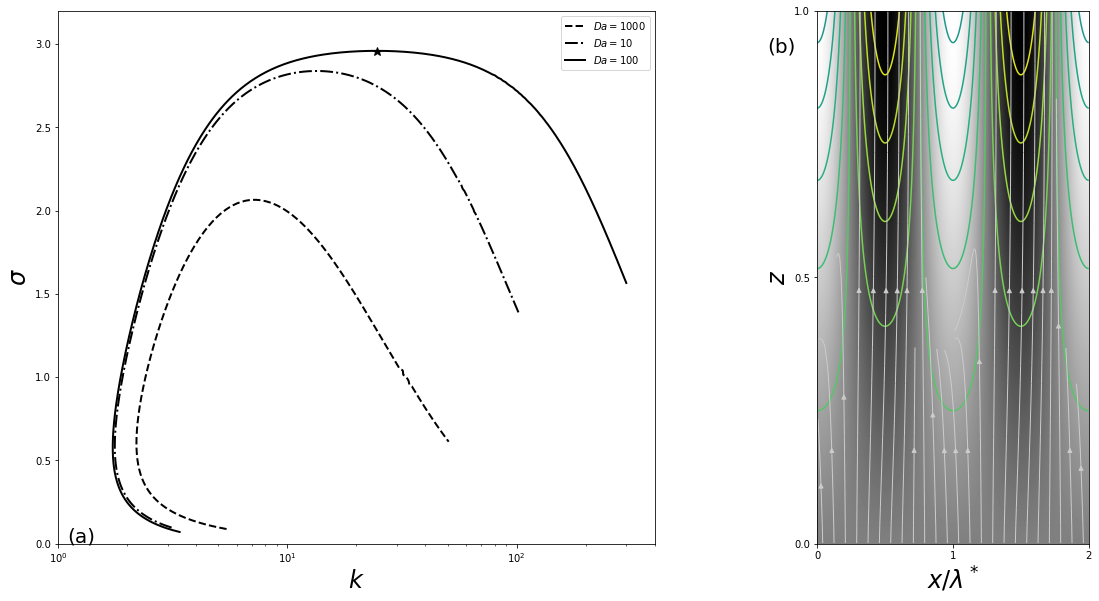

In [15]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(9.8 * zoom, 4.9 * zoom)
f.set_facecolor('w')

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])

ax0 = plt.subplot(gs[0])
ax0.plot(DC_a.k, DC_a.s, '--k', linewidth=2, label=r'$Da=1000$')
ax0.plot(DC_b.k, DC_b.s, '-.k', linewidth=2, label=r'$Da=10$')
ax0.plot(DC_ref.k, DC_ref.s, '-k', linewidth=2, label=r'$Da=100$')
ax0.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)
ax0.set_xlabel(r'$k$', fontsize=24)
ax0.set_xscale('log')
ax0.set_xlim(1.0, 400.0)
ax0.set_xticks((1e0, 1e1, 1e2))
ax0.set_ylim(0.0, 3.2)
ax0.set_ylabel(r'$\sigma$', fontsize=24)
ax0.text(1.1, 0.1, '(a)', fontsize=20, verticalalignment='top', horizontalalignment='left')
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.imshow(np.flipud(P), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax1.contour(X, Z, phi, levels=np.linspace(-1, 1, 20))
nlines = 24
h = 2.0 * lambda_/(nlines+1.0)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5*h, 2.0*lambda_-0.5*h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
ax1.streamplot(X, Z, U, W, start_points=seed, integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
ax1.set_xlabel(r'$x/\lambda^*$', fontsize=24)
ax1.set_xlim(0, 2.*lambda_)
ax1.set_xticks((0, lambda_, 2*lambda_))
ax1.set_xticklabels((0, 1, 2))
ax1.set_ylabel(r'$z$', fontsize=24)
ax1.set_ylim(0, 1)
ax1.set_yticks((0, 0.5, 1))
ax1.text(-0.04, 0.95, '(b)', fontsize=20, verticalalignment='top', horizontalalignment='right')

plt.show()

### The large-Damköhler number limit

Considering the asymptotic limit of large Damköhler number, we can reduce the polynomial \eqref{eq:characteristic-poly-cbs} to second order,
\begin{equation}
  \label{eq:characteristic-poly-quad}
  \left(\sigma\Kk - \frac{\permexp}{\Da\stiff}\right)m^2
  - \left(\frac{\permexp\Kk}{\stiff} +
    \frac{\sigma }{\Da}k^2\right)m + 
  \left(\permexp - \sigma\Kk\right)k^2 = 0.
\end{equation}

The function `characteristic_polynomial` above already includes this case and evaluatees the coefficients of the both characteristic polynomial \eqref{eq:characteristic-poly-cbs} and \eqref{eq:characteristic-poly-quad}.

In [16]:
Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])
DC_cube = {}
DC_quad = {}

for vals in [10., 100., 1000.]:
    par = PAR(Da_=vals, largeDa_=False)
    DC_cube[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

    par = PAR(Da_=vals, largeDa_=True)
    DC_quad[vals] = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=1.9700163558867765
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=1.9570167816517678
Iteration 2: searching for solution at k=4.818066292998758
SUCCESS: monotonic eigenfunction for k=4.818066292998758, sigma=1.9486469892766827
Iteration 3: searching for solution at k=4.754040003771168
SUCCESS: monotonic eigenfunction for k=4.754040003771168, sigma=1.9403553170435563
Iteration 4: searching for solution at k=4.692426291378214
SUCCESS: monotonic eigenfunction for k=4.692426291378214, sigma=1.9319700450992363
Iteration 5: searching for solution at k=4.633064371552892
SUCCESS: monotonic eigenfunction for k=4.633064371552892, sigma=1.9234983480123409
Iteration 6: searching for solution at k=4.5758148172813105
SUCCESS: monotonic eigenfunction for k=4.5758148172813105, sigma=1.9149475845022907
Iteration 7: searching for solution at k=4.520549371340002
SUCC

SUCCESS: monotonic eigenfunction for k=2.9729138927827723, sigma=1.4278576738937903
Iteration 59: searching for solution at k=2.9552660198120204
SUCCESS: monotonic eigenfunction for k=2.9552660198120204, sigma=1.4181490833015142
Iteration 60: searching for solution at k=2.9378871415763097
SUCCESS: monotonic eigenfunction for k=2.9378871415763097, sigma=1.4084342821359155
Iteration 61: searching for solution at k=2.9207714252179886
SUCCESS: monotonic eigenfunction for k=2.9207714252179886, sigma=1.3987133986216935
Iteration 62: searching for solution at k=2.9039132773538574
SUCCESS: monotonic eigenfunction for k=2.9039132773538574, sigma=1.388986553341307
Iteration 63: searching for solution at k=2.8873073341723305
SUCCESS: monotonic eigenfunction for k=2.8873073341723305, sigma=1.3792538595402484
Iteration 64: searching for solution at k=2.87094845215095
SUCCESS: monotonic eigenfunction for k=2.87094845215095, sigma=1.3695154234075526
Iteration 65: searching for solution at k=2.8548316

SUCCESS: monotonic eigenfunction for k=2.2750241875037345, sigma=0.8356673069826155
Iteration 119: searching for solution at k=2.2688289776978223
SUCCESS: monotonic eigenfunction for k=2.2688289776978223, sigma=0.8255845156693287
Iteration 120: searching for solution at k=2.262830559937383
SUCCESS: monotonic eigenfunction for k=2.262830559937383, sigma=0.8154880522816933
Iteration 121: searching for solution at k=2.2570328473925887
SUCCESS: monotonic eigenfunction for k=2.2570328473925887, sigma=0.8053768183471879
Iteration 122: searching for solution at k=2.2514400744614735
SUCCESS: monotonic eigenfunction for k=2.2514400744614735, sigma=0.7952495356617809
Iteration 123: searching for solution at k=2.2460568201002693
SUCCESS: monotonic eigenfunction for k=2.2460568201002693, sigma=0.785104703985472
Iteration 124: searching for solution at k=2.2408880341772797
SUCCESS: monotonic eigenfunction for k=2.2408880341772797, sigma=0.7749405454125572
Iteration 125: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=2.5198643275372947, sigma=0.3027903235074436
Iteration 174: searching for solution at k=2.548012128590511
SUCCESS: monotonic eigenfunction for k=2.548012128590511, sigma=0.2942982849305799
Iteration 175: searching for solution at k=2.57787067466124
SUCCESS: monotonic eigenfunction for k=2.57787067466124, sigma=0.28593205922280407
Iteration 176: searching for solution at k=2.6094951330141503
SUCCESS: monotonic eigenfunction for k=2.6094951330141503, sigma=0.2777004236221228
Iteration 177: searching for solution at k=2.6429375827710544
SUCCESS: monotonic eigenfunction for k=2.6429375827710544, sigma=0.2696119153031543
Iteration 178: searching for solution at k=2.678246569762177
SUCCESS: monotonic eigenfunction for k=2.678246569762177, sigma=0.26167470340916216
Iteration 179: searching for solution at k=2.7154667569675945
SUCCESS: monotonic eigenfunction for k=2.7154667569675945, sigma=0.2538964612624246
Iteration 180: searching for solution at k=2.7

SUCCESS: monotonic eigenfunction for k=5.071604746902777, sigma=1.977597708193289
Iteration 216: searching for solution at k=5.146882718933767
SUCCESS: monotonic eigenfunction for k=5.146882718933767, sigma=1.9850979474381596
Iteration 217: searching for solution at k=5.225450712377876
SUCCESS: monotonic eigenfunction for k=5.225450712377876, sigma=1.9924362645650278
Iteration 218: searching for solution at k=5.307540535674139
SUCCESS: monotonic eigenfunction for k=5.307540535674139, sigma=1.9995950848331292
Iteration 219: searching for solution at k=5.393405914221006
SUCCESS: monotonic eigenfunction for k=5.393405914221006, sigma=2.006554947329292
Iteration 220: searching for solution at k=5.48331794312552
SUCCESS: monotonic eigenfunction for k=5.48331794312552, sigma=2.0132937670130375
Iteration 221: searching for solution at k=5.577564058747568
SUCCESS: monotonic eigenfunction for k=5.577564058747568, sigma=2.0197865324564193
Iteration 222: searching for solution at k=5.676445373402

SUCCESS: monotonic eigenfunction for k=13.834924010611173, sigma=1.8052414378762875
Iteration 274: searching for solution at k=13.99724324120161
SUCCESS: monotonic eigenfunction for k=13.99724324120161, sigma=1.7965631208723598
Iteration 275: searching for solution at k=14.159841252078595
SUCCESS: monotonic eigenfunction for k=14.159841252078595, sigma=1.7878576325320485
Iteration 276: searching for solution at k=14.32275029949728
SUCCESS: monotonic eigenfunction for k=14.32275029949728, sigma=1.7791264306003756
Iteration 277: searching for solution at k=14.48600182610287
SUCCESS: monotonic eigenfunction for k=14.48600182610287, sigma=1.7703708732612318
Iteration 278: searching for solution at k=14.64962652472978
SUCCESS: monotonic eigenfunction for k=14.64962652472978, sigma=1.7615922279382563
Iteration 279: searching for solution at k=14.813654398587774
SUCCESS: monotonic eigenfunction for k=14.813654398587774, sigma=1.7527916791740121
Iteration 280: searching for solution at k=14.97

SUCCESS: monotonic eigenfunction for k=25.23239099851742, sigma=1.2529459389467634
Iteration 335: searching for solution at k=25.46188535008186
SUCCESS: monotonic eigenfunction for k=25.46188535008186, sigma=1.2437506850060127
Iteration 336: searching for solution at k=25.69342196127764
SUCCESS: monotonic eigenfunction for k=25.69342196127764, sigma=1.234555625585348
Iteration 337: searching for solution at k=25.927041115281583
SUCCESS: monotonic eigenfunction for k=25.927041115281583, sigma=1.2253609190556738
Iteration 338: searching for solution at k=26.16278392376278
SUCCESS: monotonic eigenfunction for k=26.16278392376278, sigma=1.2161667229456719
Iteration 339: searching for solution at k=26.400692355196142
SUCCESS: monotonic eigenfunction for k=26.400692355196142, sigma=1.206973194096563
Iteration 340: searching for solution at k=26.64080926402617
SUCCESS: monotonic eigenfunction for k=26.64080926402617, sigma=1.1977804888138661
Iteration 341: searching for solution at k=26.88317

FAILURE: no solution found for k=36.84968816790259
Iteration 371: searching for solution at sigma=0.890453733021462
SUCCESS: monotonic eigenfunction for k=36.85054885168643, sigma=0.890453733021462
Iteration 372: searching for solution at k=37.197521207422966
FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at k=37.197521207422966
FAILURE: no solution found for k=37.197521207422966
Iteration 372: searching for solution at sigma=0.8813194555832876
SUCCESS: monotonic eigenfunction for k=37.198412338626106, sigma=0.8813194555832876
Iteration 373: searching for solution at k=37.55014147435615
FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at k=37.55014147435615
FAILURE: no solution found for k=37.55014147435615
Iteration 373: searching for solution at sigma=0.8721928312731445
SUCCESS: monotonic eigenfunction for k=37.55106409072905, sigma=0.8721928312731445
Iteration 374: searching for solution at k=37.90765

SUCCESS: monotonic eigenfunction for k=45.807463996506954, sigma=0.691664859926009
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at k=46.290423296352195
FAILURE: no solution found for k=46.290423296352195
Iteration 394: searching for solution at sigma=0.6827624130273926
SUCCESS: monotonic eigenfunction for k=46.29234992546921, sigma=0.6827624130273926
Iteration 395: searching for solution at k=46.78346496832992
FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at k=46.78346496832992
FAILURE: no solution found for k=46.78346496832992
Iteration 395: searching for solution at sigma=0.6738744767640027
SUCCESS: monotonic eigenfunction for k=46.78546242179079, sigma=0.6738744767640027
Iteration 396: searching for solution at k=47.28495389807136
FAILURE: no solution found for k=47.28495389807136
Iteration 396: searching for solution at k=47.284953898

SUCCESS: monotonic eigenfunction for k=3.285803166552678, sigma=1.891459532062629
Iteration 33: searching for solution at k=3.256547092103185
SUCCESS: monotonic eigenfunction for k=3.256547092103185, sigma=1.8821619935541305
Iteration 34: searching for solution at k=3.227993394106238
SUCCESS: monotonic eigenfunction for k=3.227993394106238, sigma=1.8728414628971317
Iteration 35: searching for solution at k=3.2001128566670842
SUCCESS: monotonic eigenfunction for k=3.2001128566670842, sigma=1.8634991351129477
Iteration 36: searching for solution at k=3.172878060736905
SUCCESS: monotonic eigenfunction for k=3.172878060736905, sigma=1.8541361150508904
Iteration 37: searching for solution at k=3.146263244102575
SUCCESS: monotonic eigenfunction for k=3.146263244102575, sigma=1.8447534257525846
Iteration 38: searching for solution at k=3.1202441745892946
SUCCESS: monotonic eigenfunction for k=3.1202441745892946, sigma=1.83535201588233
Iteration 39: searching for solution at k=3.09479803504807

SUCCESS: monotonic eigenfunction for k=2.2234625156275487, sigma=1.292406768925367
Iteration 95: searching for solution at k=2.213875686110768
SUCCESS: monotonic eigenfunction for k=2.213875686110768, sigma=1.2825154659842963
Iteration 96: searching for solution at k=2.2044570409634057
SUCCESS: monotonic eigenfunction for k=2.2044570409634057, sigma=1.2726178235727093
Iteration 97: searching for solution at k=2.195205959829452
SUCCESS: monotonic eigenfunction for k=2.195205959829452, sigma=1.2627137417737577
Iteration 98: searching for solution at k=2.1861219586783713
SUCCESS: monotonic eigenfunction for k=2.1861219586783713, sigma=1.2528031089076734
Iteration 99: searching for solution at k=2.177204691491668
SUCCESS: monotonic eigenfunction for k=2.177204691491668, sigma=1.2428858006754
Iteration 100: searching for solution at k=2.1684539523192434
SUCCESS: monotonic eigenfunction for k=2.1684539523192434, sigma=1.232961679176101
Iteration 101: searching for solution at k=2.15986967772

SUCCESS: monotonic eigenfunction for k=2.0034318446076798, sigma=0.7366979980655319
Iteration 151: searching for solution at k=2.008592609095843
SUCCESS: monotonic eigenfunction for k=2.008592609095843, sigma=0.7272789998491549
Iteration 152: searching for solution at k=2.01434856268273
SUCCESS: monotonic eigenfunction for k=2.01434856268273, sigma=0.7178483670240565
Iteration 153: searching for solution at k=2.0207323262900174
SUCCESS: monotonic eigenfunction for k=2.0207323262900174, sigma=0.7084121435836154
Iteration 154: searching for solution at k=2.0277784491138284
SUCCESS: monotonic eigenfunction for k=2.0277784491138284, sigma=0.6989759804224044
Iteration 155: searching for solution at k=2.0355235214663745
SUCCESS: monotonic eigenfunction for k=2.0355235214663745, sigma=0.6895453107282234
Iteration 156: searching for solution at k=2.0440062734346793
SUCCESS: monotonic eigenfunction for k=2.0440062734346793, sigma=0.6801254872549689
Iteration 157: searching for solution at k=2.0

SUCCESS: monotonic eigenfunction for k=5.168860874100673, sigma=0.3480767921570292
Iteration 214: searching for solution at k=5.287128990650809
FAILURE: no solution found for k=5.287128990650809
Iteration 214: searching for solution at k=5.287128990650809
FAILURE: no solution found for k=5.287128990650809
Iteration 214: searching for solution at sigma=0.3462135259973457
SUCCESS: monotonic eigenfunction for k=5.2891841529326395, sigma=0.3462135259973457
Iteration 215: searching for solution at k=5.410350116416638
FAILURE: no solution found for k=5.410350116416638
Iteration 215: searching for solution at k=5.410350116416638
FAILURE: no solution found for k=5.410350116416638
Iteration 215: searching for solution at sigma=0.34441272357138125
SUCCESS: monotonic eigenfunction for k=5.412415917582895, sigma=0.34441272357138125
Iteration 216: searching for solution at k=5.536539838102269
SUCCESS: monotonic eigenfunction for k=5.536539838102269, sigma=0.3426981144713648
Iteration 217: searching

SUCCESS: monotonic eigenfunction for k=6.369017860199212, sigma=2.1715422193656244
Iteration 245: searching for solution at k=6.511608000017692
SUCCESS: monotonic eigenfunction for k=6.511608000017692, sigma=2.168341129155413
Iteration 246: searching for solution at k=6.653858622863814
SUCCESS: monotonic eigenfunction for k=6.653858622863814, sigma=2.164479208238686
Iteration 247: searching for solution at k=6.79520793988987
SUCCESS: monotonic eigenfunction for k=6.79520793988987, sigma=2.1600257708629087
Iteration 248: searching for solution at k=6.935252709879812
SUCCESS: monotonic eigenfunction for k=6.935252709879812, sigma=2.155048746194321
Iteration 249: searching for solution at k=7.073727204593501
SUCCESS: monotonic eigenfunction for k=7.073727204593501, sigma=2.1496115519228427
Iteration 250: searching for solution at k=7.210475812868525
SUCCESS: monotonic eigenfunction for k=7.210475812868525, sigma=2.1437714736853013
Iteration 251: searching for solution at k=7.3454260773050

SUCCESS: monotonic eigenfunction for k=13.432029757769563, sigma=1.6780608244571804
Iteration 305: searching for solution at k=13.547410818719149
SUCCESS: monotonic eigenfunction for k=13.547410818719149, sigma=1.6687542839512188
Iteration 306: searching for solution at k=13.663293018795319
SUCCESS: monotonic eigenfunction for k=13.663293018795319, sigma=1.6594425878354107
Iteration 307: searching for solution at k=13.779697320824054
SUCCESS: monotonic eigenfunction for k=13.779697320824054, sigma=1.6501260579048451
Iteration 308: searching for solution at k=13.896644739428256
SUCCESS: monotonic eigenfunction for k=13.896644739428256, sigma=1.6408050038895647
Iteration 309: searching for solution at k=14.014156363103513
SUCCESS: monotonic eigenfunction for k=14.014156363103513, sigma=1.63147972430807
Iteration 310: searching for solution at k=14.132253375817694
SUCCESS: monotonic eigenfunction for k=14.132253375817694, sigma=1.6221505072606455
Iteration 311: searching for solution at k

SUCCESS: monotonic eigenfunction for k=22.29595998405548, sigma=1.10936314551239
Iteration 366: searching for solution at k=22.493569989760847
SUCCESS: monotonic eigenfunction for k=22.493569989760847, sigma=1.1001526311252894
Iteration 367: searching for solution at k=22.693884623688373
SUCCESS: monotonic eigenfunction for k=22.693884623688373, sigma=1.0909504080659833
Iteration 368: searching for solution at k=22.89697511188029
SUCCESS: monotonic eigenfunction for k=22.89697511188029, sigma=1.0817567578695622
Iteration 369: searching for solution at k=23.102914756348973
SUCCESS: monotonic eigenfunction for k=23.102914756348973, sigma=1.0725719682623547
Iteration 370: searching for solution at k=23.311778998620877
SUCCESS: monotonic eigenfunction for k=23.311778998620877, sigma=1.0633963333326926
Iteration 371: searching for solution at k=23.523645484282017
SUCCESS: monotonic eigenfunction for k=23.523645484282017, sigma=1.0542301536957503
Iteration 372: searching for solution at k=23

SUCCESS: monotonic eigenfunction for k=42.144349260947436, sigma=0.5920726702614759
Iteration 425: searching for solution at k=42.71596677464987
SUCCESS: monotonic eigenfunction for k=42.71596677464987, sigma=0.584007340809385
Iteration 426: searching for solution at k=43.29957194522493
SUCCESS: monotonic eigenfunction for k=43.29957194522493, sigma=0.5759724065665025
Iteration 427: searching for solution at k=43.895418314128754
SUCCESS: monotonic eigenfunction for k=43.895418314128754, sigma=0.5679680157431449
Iteration 428: searching for solution at k=44.503763551636936
SUCCESS: monotonic eigenfunction for k=44.503763551636936, sigma=0.55999430359557
Iteration 429: searching for solution at k=45.12486976989016
SUCCESS: monotonic eigenfunction for k=45.12486976989016, sigma=0.5520513941359662
Iteration 430: searching for solution at k=45.75900387493564
SUCCESS: monotonic eigenfunction for k=45.75900387493564, sigma=0.5441394020623829
Iteration 431: searching for solution at k=46.40643

SUCCESS: monotonic eigenfunction for k=3.3536024687496675, sigma=2.143193948139825
Iteration 44: searching for solution at k=3.3301054963283554
SUCCESS: monotonic eigenfunction for k=3.3301054963283554, sigma=2.133624942318503
Iteration 45: searching for solution at k=3.3069800203457373
SUCCESS: monotonic eigenfunction for k=3.3069800203457373, sigma=2.1240478398123455
Iteration 46: searching for solution at k=3.284216432092171
SUCCESS: monotonic eigenfunction for k=3.284216432092171, sigma=2.11446288596216
Iteration 47: searching for solution at k=3.261805462140537
SUCCESS: monotonic eigenfunction for k=3.261805462140537, sigma=2.1048703161175832
Iteration 48: searching for solution at k=3.239738165927911
SUCCESS: monotonic eigenfunction for k=3.239738165927911, sigma=2.0952703561089883
Iteration 49: searching for solution at k=3.2180059100490706
SUCCESS: monotonic eigenfunction for k=3.2180059100490706, sigma=2.085663222693404
Iteration 50: searching for solution at k=3.1966003592232

SUCCESS: monotonic eigenfunction for k=2.4066615610222093, sigma=1.5795785445804236
Iteration 102: searching for solution at k=2.395361830585052
SUCCESS: monotonic eigenfunction for k=2.395361830585052, sigma=1.5697604192073427
Iteration 103: searching for solution at k=2.384179245613317
SUCCESS: monotonic eigenfunction for k=2.384179245613317, sigma=1.5599399075083182
Iteration 104: searching for solution at k=2.3731122049848556
SUCCESS: monotonic eigenfunction for k=2.3731122049848556, sigma=1.5501170312068282
Iteration 105: searching for solution at k=2.362159155094859
SUCCESS: monotonic eigenfunction for k=2.362159155094859, sigma=1.540291810578415
Iteration 106: searching for solution at k=2.3513185888343586
SUCCESS: monotonic eigenfunction for k=2.3513185888343586, sigma=1.5304642644635287
Iteration 107: searching for solution at k=2.340589044618763
SUCCESS: monotonic eigenfunction for k=2.340589044618763, sigma=1.5206344102783758
Iteration 108: searching for solution at k=2.3299

SUCCESS: monotonic eigenfunction for k=1.8953029173209601, sigma=0.9762711784610705
Iteration 163: searching for solution at k=1.8896581042163585
SUCCESS: monotonic eigenfunction for k=1.8896581042163585, sigma=0.966285550382119
Iteration 164: searching for solution at k=1.8841061196004725
SUCCESS: monotonic eigenfunction for k=1.8841061196004725, sigma=0.95629496260553
Iteration 165: searching for solution at k=1.8786480501394238
SUCCESS: monotonic eigenfunction for k=1.8786480501394238, sigma=0.9462992052425874
Iteration 166: searching for solution at k=1.8732850637155467
SUCCESS: monotonic eigenfunction for k=1.8732850637155467, sigma=0.9362980509331611
Iteration 167: searching for solution at k=1.8680184133058308
SUCCESS: monotonic eigenfunction for k=1.8680184133058308, sigma=0.9262912528229218
Iteration 168: searching for solution at k=1.8628494411547283
SUCCESS: monotonic eigenfunction for k=1.8628494411547283, sigma=0.9162785422216279
Iteration 169: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.804891708882168, sigma=0.42956263886461854
Iteration 218: searching for solution at k=1.8107456282756327
SUCCESS: monotonic eigenfunction for k=1.8107456282756327, sigma=0.42007900354197647
Iteration 219: searching for solution at k=1.8171357795622312
SUCCESS: monotonic eigenfunction for k=1.8171357795622312, sigma=0.41059994209275624
Iteration 220: searching for solution at k=1.824091971181933
SUCCESS: monotonic eigenfunction for k=1.824091971181933, sigma=0.40112946954894513
Iteration 221: searching for solution at k=1.831645809538268
SUCCESS: monotonic eigenfunction for k=1.831645809538268, sigma=0.39167165854525576
Iteration 222: searching for solution at k=1.8398307773881555
SUCCESS: monotonic eigenfunction for k=1.8398307773881555, sigma=0.3822307022970918
Iteration 223: searching for solution at k=1.848682302418577
SUCCESS: monotonic eigenfunction for k=1.848682302418577, sigma=0.37281097052691525
Iteration 224: searching for solution at 

SUCCESS: monotonic eigenfunction for k=5.315660987733552, sigma=2.590784810073916
Iteration 267: searching for solution at k=5.38439913363786
SUCCESS: monotonic eigenfunction for k=5.38439913363786, sigma=2.59898633255328
Iteration 268: searching for solution at k=5.455155824746044
SUCCESS: monotonic eigenfunction for k=5.455155824746044, sigma=2.6071252024841516
Iteration 269: searching for solution at k=5.5280145910106535
SUCCESS: monotonic eigenfunction for k=5.5280145910106535, sigma=2.615198443821011
Iteration 270: searching for solution at k=5.6030626201162805
SUCCESS: monotonic eigenfunction for k=5.6030626201162805, sigma=2.623202932095262
Iteration 271: searching for solution at k=5.680390855618926
SUCCESS: monotonic eigenfunction for k=5.680390855618926, sigma=2.631135389448545
Iteration 272: searching for solution at k=5.760094085194347
SUCCESS: monotonic eigenfunction for k=5.760094085194347, sigma=2.6389923800386033
Iteration 273: searching for solution at k=5.842271016618

SUCCESS: monotonic eigenfunction for k=16.25839091702534, sigma=2.830266454865779
Iteration 325: searching for solution at k=16.629111024257174
SUCCESS: monotonic eigenfunction for k=16.629111024257174, sigma=2.828099991837418
Iteration 326: searching for solution at k=17.006236713683098
SUCCESS: monotonic eigenfunction for k=17.006236713683098, sigma=2.825696963348065
Iteration 327: searching for solution at k=17.389601102554145
SUCCESS: monotonic eigenfunction for k=17.389601102554145, sigma=2.8230594889803515
Iteration 328: searching for solution at k=17.779021831670136
SUCCESS: monotonic eigenfunction for k=17.779021831670136, sigma=2.8201899742685903
Iteration 329: searching for solution at k=18.17430177363859
SUCCESS: monotonic eigenfunction for k=18.17430177363859, sigma=2.8170911209046685
Iteration 330: searching for solution at k=18.575229964878613
SUCCESS: monotonic eigenfunction for k=18.575229964878613, sigma=2.813765933887421
Iteration 331: searching for solution at k=18.9

SUCCESS: monotonic eigenfunction for k=42.20989463467861, sigma=2.446527669584268
Iteration 383: searching for solution at k=42.669476052116636
SUCCESS: monotonic eigenfunction for k=42.669476052116636, sigma=2.437641409967728
Iteration 384: searching for solution at k=43.12899539604707
SUCCESS: monotonic eigenfunction for k=43.12899539604707, sigma=2.4287293398653214
Iteration 385: searching for solution at k=43.58848121157462
SUCCESS: monotonic eigenfunction for k=43.58848121157462, sigma=2.4197925223746175
Iteration 386: searching for solution at k=44.047962755624056
SUCCESS: monotonic eigenfunction for k=44.047962755624056, sigma=2.410831968508429
Iteration 387: searching for solution at k=44.50746991576415
SUCCESS: monotonic eigenfunction for k=44.50746991576415, sigma=2.4018486400775085
Iteration 388: searching for solution at k=44.96703313721823
SUCCESS: monotonic eigenfunction for k=44.96703313721823, sigma=2.3928434524113986
Iteration 389: searching for solution at k=45.426683

FAILURE: no solution found for k=62.82810033716283
Iteration 423: searching for solution at k=62.82810033716283
FAILURE: no solution found for k=62.82810033716283
Iteration 423: searching for solution at sigma=2.045244158767068
SUCCESS: monotonic eigenfunction for k=62.82684532086985, sigma=2.045244158767068
Iteration 424: searching for solution at k=63.31031115106414
FAILURE: no solution found for k=63.31031115106414
Iteration 424: searching for solution at k=63.31031115106414
FAILURE: no solution found for k=63.31031115106414
Iteration 424: searching for solution at sigma=2.0358145948782758
SUCCESS: monotonic eigenfunction for k=63.309079919034374, sigma=2.0358145948782758
Iteration 425: searching for solution at k=63.794018396613716
FAILURE: no solution found for k=63.794018396613716
Iteration 425: searching for solution at k=63.794018396613716
FAILURE: no solution found for k=63.794018396613716
Iteration 425: searching for solution at sigma=2.026379665763015
SUCCESS: monotonic eige

FAILURE: no solution found for k=74.62731687220918
Iteration 446: searching for solution at sigma=1.8224384302562784
SUCCESS: monotonic eigenfunction for k=74.62657021516691, sigma=1.8224384302562784
Iteration 447: searching for solution at k=75.15442940950933
FAILURE: no solution found for k=75.15442940950933
Iteration 447: searching for solution at k=75.15442940950933
FAILURE: no solution found for k=75.15442940950933
Iteration 447: searching for solution at sigma=1.8129184657726078
SUCCESS: monotonic eigenfunction for k=75.15370303702585, sigma=1.8129184657726078
Iteration 448: searching for solution at k=75.68394087633432
FAILURE: no solution found for k=75.68394087633432
Iteration 448: searching for solution at k=75.68394087633432
FAILURE: no solution found for k=75.68394087633432
Iteration 448: searching for solution at sigma=1.8033960141751781
SUCCESS: monotonic eigenfunction for k=75.68323476201248, sigma=1.8033960141751781
Iteration 449: searching for solution at k=76.21589521

SUCCESS: monotonic eigenfunction for k=87.44109427281748, sigma=1.6029977315071013
Iteration 470: searching for solution at k=88.03595288984278
FAILURE: no solution found for k=88.03595288984278
Iteration 470: searching for solution at k=88.03595288984278
FAILURE: no solution found for k=88.03595288984278
Iteration 470: searching for solution at sigma=1.5934410578501073
SUCCESS: monotonic eigenfunction for k=88.03570493609155, sigma=1.5934410578501073
Iteration 471: searching for solution at k=88.63413050829446
FAILURE: no solution found for k=88.63413050829446
Iteration 471: searching for solution at k=88.63413050829446
FAILURE: no solution found for k=88.63413050829446
Iteration 471: searching for solution at sigma=1.5838836626871298
SUCCESS: monotonic eigenfunction for k=88.6339048570544, sigma=1.5838836626871298
Iteration 472: searching for solution at k=89.23595947296924
FAILURE: no solution found for k=89.23595947296924
Iteration 472: searching for solution at k=89.23595947296924

FAILURE: no solution found for k=102.14609420764717
Iteration 492: searching for solution at sigma=1.383127572422559
SUCCESS: monotonic eigenfunction for k=102.14640653129422, sigma=1.383127572422559
Iteration 493: searching for solution at k=102.84123977673866
FAILURE: no solution found for k=102.84123977673866
Iteration 493: searching for solution at k=102.84123977673866
FAILURE: no solution found for k=102.84123977673866
Iteration 493: searching for solution at sigma=1.3735708141862932
SUCCESS: monotonic eigenfunction for k=102.84158230697763, sigma=1.3735708141862932
Iteration 494: searching for solution at k=103.54174854717154
FAILURE: no solution found for k=103.54174854717154
Iteration 494: searching for solution at k=103.54174854717154
FAILURE: no solution found for k=103.54174854717154
Iteration 494: searching for solution at sigma=1.3640148369963743
FAILURE: non-monotonic eigenfunction for k=103.54212183782042, sigma=1.3640148369963743
SUCCESS: monotonic eigenfunction for k=5

SUCCESS: monotonic eigenfunction for k=3.1504054630694887, sigma=2.0831167415086935
Iteration 52: searching for solution at k=3.1295200797721985
SUCCESS: monotonic eigenfunction for k=3.1295200797721985, sigma=2.07349993291985
Iteration 53: searching for solution at k=3.1089442116519628
SUCCESS: monotonic eigenfunction for k=3.1089442116519628, sigma=2.06387644131964
Iteration 54: searching for solution at k=3.08867035042777
SUCCESS: monotonic eigenfunction for k=3.08867035042777, sigma=2.054246454799245
Iteration 55: searching for solution at k=3.068691240620096
SUCCESS: monotonic eigenfunction for k=3.068691240620096, sigma=2.044610154097344
Iteration 56: searching for solution at k=3.0489998693231395
SUCCESS: monotonic eigenfunction for k=3.0489998693231395, sigma=2.034967712927776
Iteration 57: searching for solution at k=3.0295894564649677
SUCCESS: monotonic eigenfunction for k=3.0295894564649677, sigma=2.025319298289749
Iteration 58: searching for solution at k=3.010453445529907


SUCCESS: monotonic eigenfunction for k=2.283209618486987, sigma=1.5082142056088792
Iteration 111: searching for solution at k=2.2729441566421573
SUCCESS: monotonic eigenfunction for k=2.2729441566421573, sigma=1.498378049903574
Iteration 112: searching for solution at k=2.2627836863273045
SUCCESS: monotonic eigenfunction for k=2.2627836863273045, sigma=1.4885395957841383
Iteration 113: searching for solution at k=2.2527269760473234
SUCCESS: monotonic eigenfunction for k=2.2527269760473234, sigma=1.4786988531722678
Iteration 114: searching for solution at k=2.2427728351502054
SUCCESS: monotonic eigenfunction for k=2.2427728351502054, sigma=1.4688558305402726
Iteration 115: searching for solution at k=2.232920113184398
SUCCESS: monotonic eigenfunction for k=2.232920113184398, sigma=1.4590105349062776
Iteration 116: searching for solution at k=2.2231676992986347
SUCCESS: monotonic eigenfunction for k=2.2231676992986347, sigma=1.449162971827151
Iteration 117: searching for solution at k=2.

SUCCESS: monotonic eigenfunction for k=1.8394955831485713, sigma=0.9335052215204857
Iteration 169: searching for solution at k=1.834469911893812
SUCCESS: monotonic eigenfunction for k=1.834469911893812, sigma=0.9234860413719316
Iteration 170: searching for solution at k=1.8295448297123431
SUCCESS: monotonic eigenfunction for k=1.8295448297123431, sigma=0.9134602420080946
Iteration 171: searching for solution at k=1.8247219721552101
SUCCESS: monotonic eigenfunction for k=1.8247219721552101, sigma=0.9034274652256378
Iteration 172: searching for solution at k=1.8200030845984347
SUCCESS: monotonic eigenfunction for k=1.8200030845984347, sigma=0.8933873161274513
Iteration 173: searching for solution at k=1.815390028377735
SUCCESS: monotonic eigenfunction for k=1.815390028377735, sigma=0.8833393577287526
Iteration 174: searching for solution at k=1.810884787440504
SUCCESS: monotonic eigenfunction for k=1.810884787440504, sigma=0.8732831045039819
Iteration 175: searching for solution at k=1.8

SUCCESS: monotonic eigenfunction for k=1.8429318446007295, sigma=0.3753849964049284
Iteration 226: searching for solution at k=1.8536967499645771
SUCCESS: monotonic eigenfunction for k=1.8536967499645771, sigma=0.3660481384604111
Iteration 227: searching for solution at k=1.865268096867305
SUCCESS: monotonic eigenfunction for k=1.865268096867305, sigma=0.3567512201986719
Iteration 228: searching for solution at k=1.8776900580579898
SUCCESS: monotonic eigenfunction for k=1.8776900580579898, sigma=0.3475000357593406
Iteration 229: searching for solution at k=1.8910086983550325
SUCCESS: monotonic eigenfunction for k=1.8910086983550325, sigma=0.33830077840684086
Iteration 230: searching for solution at k=1.9052718669973145
SUCCESS: monotonic eigenfunction for k=1.9052718669973145, sigma=0.3291600621238877
Iteration 231: searching for solution at k=1.920529044538187
SUCCESS: monotonic eigenfunction for k=1.920529044538187, sigma=0.320084935440711
Iteration 232: searching for solution at k=1

FAILURE: no solution found for k=5.464569357262443
Iteration 287: searching for solution at sigma=0.05591315645173407
SUCCESS: monotonic eigenfunction for k=5.467499527656205, sigma=0.05591315645173407
Iteration 288: searching for solution at k=5.593925778736412
SUCCESS: monotonic eigenfunction for k=5.593925778736412, sigma=0.05474122377266737
Iteration 289: searching for solution at k=5.723360595947263
SUCCESS: monotonic eigenfunction for k=5.723360595947263, sigma=0.05362223212257083
Iteration 290: searching for solution at k=5.855868656222297
SUCCESS: monotonic eigenfunction for k=5.855868656222297, sigma=0.052553752004089224
Iteration 291: searching for solution at k=5.991517533674739
FAILURE: no solution found for k=5.991517533674739
Iteration 291: searching for solution at k=5.991517533674739
FAILURE: no solution found for k=5.991517533674739
Iteration 291: searching for solution at sigma=0.05151028512727248
SUCCESS: monotonic eigenfunction for k=5.994709573443864, sigma=0.05151

SUCCESS: monotonic eigenfunction for k=12.254487149366208, sigma=2.8411161136176357
Iteration 343: searching for solution at k=12.538978789724812
SUCCESS: monotonic eigenfunction for k=12.538978789724812, sigma=2.841832935148492
Iteration 344: searching for solution at k=12.830587980551371
SUCCESS: monotonic eigenfunction for k=12.830587980551371, sigma=2.8423084418402516
Iteration 345: searching for solution at k=13.129326908740266
SUCCESS: monotonic eigenfunction for k=13.129326908740266, sigma=2.842542271483178
Iteration 346: searching for solution at k=13.435196464369412
SUCCESS: monotonic eigenfunction for k=13.435196464369412, sigma=2.8425342137759007
Iteration 347: searching for solution at k=13.748185526341114
SUCCESS: monotonic eigenfunction for k=13.748185526341114, sigma=2.842284207356532
Iteration 348: searching for solution at k=14.068270233376916
SUCCESS: monotonic eigenfunction for k=14.068270233376916, sigma=2.841792340212382
Iteration 349: searching for solution at k=1

SUCCESS: monotonic eigenfunction for k=38.673586075287915, sigma=2.5113140111410965
Iteration 406: searching for solution at k=39.12920287497586
SUCCESS: monotonic eigenfunction for k=39.12920287497586, sigma=2.502633831673416
Iteration 407: searching for solution at k=39.584543920173026
SUCCESS: monotonic eigenfunction for k=39.584543920173026, sigma=2.4939187595557923
Iteration 408: searching for solution at k=40.03963146660634
SUCCESS: monotonic eigenfunction for k=40.03963146660634, sigma=2.4851703294477643
Iteration 409: searching for solution at k=40.494489346470075
SUCCESS: monotonic eigenfunction for k=40.494489346470075, sigma=2.4763899974733863
Iteration 410: searching for solution at k=40.94914280170985
SUCCESS: monotonic eigenfunction for k=40.94914280170985, sigma=2.4675791455145704
Iteration 411: searching for solution at k=41.40361833243522
SUCCESS: monotonic eigenfunction for k=41.40361833243522, sigma=2.458739085294017
Iteration 412: searching for solution at k=41.8579

SUCCESS: monotonic eigenfunction for k=63.161654831913005, sigma=2.0247063378832455
Iteration 459: searching for solution at k=63.64698680191187
SUCCESS: monotonic eigenfunction for k=63.64698680191187, sigma=2.0152514536547694
Iteration 460: searching for solution at k=64.13383965332784
SUCCESS: monotonic eigenfunction for k=64.13383965332784, sigma=2.005791860455522
Iteration 461: searching for solution at k=64.62225125197294
SUCCESS: monotonic eigenfunction for k=64.62225125197294, sigma=1.9963277183541064
Iteration 462: searching for solution at k=65.11225968445578
SUCCESS: monotonic eigenfunction for k=65.11225968445578, sigma=1.9868591825436308
Iteration 463: searching for solution at k=65.60390327008697
SUCCESS: monotonic eigenfunction for k=65.60390327008697, sigma=1.9773864035594089
Iteration 464: searching for solution at k=66.09722057300955
SUCCESS: monotonic eigenfunction for k=66.09722057300955, sigma=1.9679095274863143
Iteration 465: searching for solution at k=66.5922504

SUCCESS: monotonic eigenfunction for k=3.2421465464038626, sigma=2.1424344719348483
Iteration 49: searching for solution at k=3.220345414510333
SUCCESS: monotonic eigenfunction for k=3.220345414510333, sigma=2.132829845809937
Iteration 50: searching for solution at k=3.1988709536468964
SUCCESS: monotonic eigenfunction for k=3.1988709536468964, sigma=2.123218265732237
Iteration 51: searching for solution at k=3.177715164567477
SUCCESS: monotonic eigenfunction for k=3.177715164567477, sigma=2.113599930016399
Iteration 52: searching for solution at k=3.156870315761854
SUCCESS: monotonic eigenfunction for k=3.156870315761854, sigma=2.1039750293362696
Iteration 53: searching for solution at k=3.1363289327295534
SUCCESS: monotonic eigenfunction for k=3.1363289327295534, sigma=2.0943437470620374
Iteration 54: searching for solution at k=3.1160837877522236
SUCCESS: monotonic eigenfunction for k=3.1160837877522236, sigma=2.08470625957996
Iteration 55: searching for solution at k=3.0961278901394

SUCCESS: monotonic eigenfunction for k=2.3390512482984356, sigma=1.5679726778474534
Iteration 108: searching for solution at k=2.32835550207375
SUCCESS: monotonic eigenfunction for k=2.32835550207375, sigma=1.5581446929816043
Iteration 109: searching for solution at k=2.3177670063211164
SUCCESS: monotonic eigenfunction for k=2.3177670063211164, sigma=1.5483145149874742
Iteration 110: searching for solution at k=2.307284382922224
SUCCESS: monotonic eigenfunction for k=2.307284382922224, sigma=1.5384821603497183
Iteration 111: searching for solution at k=2.2969062946533763
SUCCESS: monotonic eigenfunction for k=2.2969062946533763, sigma=1.5286476442632169
Iteration 112: searching for solution at k=2.2866314443945464
SUCCESS: monotonic eigenfunction for k=2.2866314443945464, sigma=1.5188109806390828
Iteration 113: searching for solution at k=2.2764585743790517
SUCCESS: monotonic eigenfunction for k=2.2764585743790517, sigma=1.5089721821089952
Iteration 114: searching for solution at k=2.2

SUCCESS: monotonic eigenfunction for k=1.868691063371459, sigma=0.9942222572420399
Iteration 166: searching for solution at k=1.863034925934607
SUCCESS: monotonic eigenfunction for k=1.863034925934607, sigma=0.9842456613776414
Iteration 167: searching for solution at k=1.8574653515414896
SUCCESS: monotonic eigenfunction for k=1.8574653515414896, sigma=0.9742646238654475
Iteration 168: searching for solution at k=1.8519832481815612
SUCCESS: monotonic eigenfunction for k=1.8519832481815612, sigma=0.9642789700821592
Iteration 169: searching for solution at k=1.8465895936937105
SUCCESS: monotonic eigenfunction for k=1.8465895936937105, sigma=0.954288511854801
Iteration 170: searching for solution at k=1.8412854389229767
SUCCESS: monotonic eigenfunction for k=1.8412854389229767, sigma=0.9442930460200022
Iteration 171: searching for solution at k=1.8360719111082948
SUCCESS: monotonic eigenfunction for k=1.8360719111082948, sigma=0.93429235277292
Iteration 172: searching for solution at k=1.8

SUCCESS: monotonic eigenfunction for k=1.752669375181695, sigma=0.45374273809779403
Iteration 220: searching for solution at k=1.7568172977932575
SUCCESS: monotonic eigenfunction for k=1.7568172977932575, sigma=0.44427023463690596
Iteration 221: searching for solution at k=1.7613993102252226
SUCCESS: monotonic eigenfunction for k=1.7613993102252226, sigma=0.43478832072818624
Iteration 222: searching for solution at k=1.7664389469880004
SUCCESS: monotonic eigenfunction for k=1.7664389469880004, sigma=0.42530133698631006
Iteration 223: searching for solution at k=1.7719611726714593
SUCCESS: monotonic eigenfunction for k=1.7719611726714593, sigma=0.4158133826594287
Iteration 224: searching for solution at k=1.7779924734194665
SUCCESS: monotonic eigenfunction for k=1.7779924734194665, sigma=0.406328424693666
Iteration 225: searching for solution at k=1.7845609453255313
SUCCESS: monotonic eigenfunction for k=1.7845609453255313, sigma=0.39685038643333737
Iteration 226: searching for solution

FAILURE: no solution found for k=3.0986485777531727
Iteration 267: searching for solution at k=3.0986485777531727
FAILURE: no solution found for k=3.0986485777531727
Iteration 267: searching for solution at sigma=0.08404219986401312
SUCCESS: monotonic eigenfunction for k=3.100409630751658, sigma=0.08404219986401312
Iteration 268: searching for solution at k=3.1671156701314507
FAILURE: no solution found for k=3.1671156701314507
Iteration 268: searching for solution at k=3.1671156701314507
FAILURE: no solution found for k=3.1671156701314507
Iteration 268: searching for solution at sigma=0.0802263138256385
SUCCESS: monotonic eigenfunction for k=3.1689160470997333, sigma=0.0802263138256385
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at k=3.237607017421601
FAILURE: no solution found for k=3.237607017421601
Iteration 269: searching for solution at sigma=0.07658126376116571
SUCCESS: monot

SUCCESS: monotonic eigenfunction for k=10.259709505208042, sigma=2.8917372543326874
Iteration 316: searching for solution at k=10.478169715243633
SUCCESS: monotonic eigenfunction for k=10.478169715243633, sigma=2.895688519700251
Iteration 317: searching for solution at k=10.702818966973396
SUCCESS: monotonic eigenfunction for k=10.702818966973396, sigma=2.8994971485113368
Iteration 318: searching for solution at k=10.933774080434999
SUCCESS: monotonic eigenfunction for k=10.933774080434999, sigma=2.90316452030154
Iteration 319: searching for solution at k=11.171152783894533
SUCCESS: monotonic eigenfunction for k=11.171152783894533, sigma=2.906692233712533
Iteration 320: searching for solution at k=11.415074017957389
SUCCESS: monotonic eigenfunction for k=11.415074017957389, sigma=2.910082086905871
Iteration 321: searching for solution at k=11.665658243125462
SUCCESS: monotonic eigenfunction for k=11.665658243125462, sigma=2.913336056887695
Iteration 322: searching for solution at k=11.

SUCCESS: monotonic eigenfunction for k=38.12443111675958, sigma=2.9450071444494808
Iteration 374: searching for solution at k=39.00071178408519
SUCCESS: monotonic eigenfunction for k=39.00071178408519, sigma=2.9433403657085746
Iteration 375: searching for solution at k=39.8955807317758
SUCCESS: monotonic eigenfunction for k=39.8955807317758, sigma=2.941571916407713
Iteration 376: searching for solution at k=40.80925440208389
SUCCESS: monotonic eigenfunction for k=40.80925440208389, sigma=2.939699373753584
Iteration 377: searching for solution at k=41.74193322784286
SUCCESS: monotonic eigenfunction for k=41.74193322784286, sigma=2.937720251417778
Iteration 378: searching for solution at k=42.693799612093876
SUCCESS: monotonic eigenfunction for k=42.693799612093876, sigma=2.935632010475406
Iteration 379: searching for solution at k=43.6650158190177
SUCCESS: monotonic eigenfunction for k=43.6650158190177, sigma=2.9334320715106803
Iteration 380: searching for solution at k=44.6557217902066

FAILURE: non-monotonic eigenfunction for k=99.6687821398475, sigma=2.7136548959235465
Iteration 420: searching for solution at k=99.6687821398475
FAILURE: non-monotonic eigenfunction for k=99.6687821398475, sigma=2.7136548959235465
Iteration 420: searching for solution at sigma=2.7171503661989305
SUCCESS: monotonic eigenfunction for k=100.61071727575087, sigma=2.7171503661989305
Iteration 421: searching for solution at k=102.4766183616969
SUCCESS: monotonic eigenfunction for k=102.4766183616969, sigma=2.7058012584707747
Iteration 422: searching for solution at k=103.70313648096845
FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at k=103.70313648096845
FAILURE: non-monotonic eigenfunction for k=103.70313648096845, sigma=2.6937281397272814
Iteration 422: searching for solution at sigma=2.6971123364865974
SUCCESS: monotonic eigenfunction for k=104.52873070353834, sigma=2.6971123364865974
Iteration 423: searching

FAILURE: no solution found for k=138.73954705054393
Iteration 444: searching for solution at k=138.73954705054393
FAILURE: no solution found for k=138.73954705054393
Iteration 444: searching for solution at sigma=2.5055422240266236
SUCCESS: monotonic eigenfunction for k=138.82151756061455, sigma=2.5055422240266236
Iteration 445: searching for solution at k=140.3243569293641
FAILURE: no solution found for k=140.3243569293641
Iteration 445: searching for solution at k=140.3243569293641
FAILURE: no solution found for k=140.3243569293641
Iteration 445: searching for solution at sigma=2.496702810810375
SUCCESS: monotonic eigenfunction for k=140.31370228542468, sigma=2.496702810810375
Iteration 446: searching for solution at k=141.81567179313137
FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at k=141.81567179313137
FAILURE: no solution found for k=141.81567179313137
Iteration 446: searching for solution at sigma=2.4878360211282993
SUCCESS: monotonic

FAILURE: no solution found for k=170.1451440681455
Iteration 465: searching for solution at sigma=2.315354748226993
SUCCESS: monotonic eigenfunction for k=170.13804557242162, sigma=2.315354748226993
Iteration 466: searching for solution at k=171.64143626326944
FAILURE: no solution found for k=171.64143626326944
Iteration 466: searching for solution at k=171.64143626326944
FAILURE: no solution found for k=171.64143626326944
Iteration 466: searching for solution at sigma=2.3061133664223608
SUCCESS: monotonic eigenfunction for k=171.63446968242843, sigma=2.3061133664223608
Iteration 467: searching for solution at k=173.13888999939525
FAILURE: no solution found for k=173.13888999939525
Iteration 467: searching for solution at k=173.13888999939525
FAILURE: no solution found for k=173.13888999939525
Iteration 467: searching for solution at sigma=2.2968594018280606
SUCCESS: monotonic eigenfunction for k=173.13205252827038, sigma=2.2968594018280606
Iteration 468: searching for solution at k=17

SUCCESS: monotonic eigenfunction for k=203.48044741653968, sigma=2.1096839715650426
Iteration 488: searching for solution at k=205.0302467518256
FAILURE: no solution found for k=205.0302467518256
Iteration 488: searching for solution at k=205.0302467518256
FAILURE: no solution found for k=205.0302467518256
Iteration 488: searching for solution at sigma=2.10024248808226
SUCCESS: monotonic eigenfunction for k=205.02561661864343, sigma=2.10024248808226
Iteration 489: searching for solution at k=206.57874756551445
FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at k=206.57874756551445
FAILURE: no solution found for k=206.57874756551445
Iteration 489: searching for solution at sigma=2.0907948334607704
SUCCESS: monotonic eigenfunction for k=206.5742043402678, sigma=2.0907948334607704
Iteration 490: searching for solution at k=208.1307770921261
FAILURE: no solution found for k=208.1307770921261
Iteration 490: searching for solution at k=208.1307770921

SUCCESS: monotonic eigenfunction for k=238.43697455586153, sigma=1.90079932137288
Iteration 510: searching for solution at k=240.08662237375376
FAILURE: no solution found for k=240.08662237375376
Iteration 510: searching for solution at k=240.08662237375376
FAILURE: no solution found for k=240.08662237375376
Iteration 510: searching for solution at sigma=1.8912581527174002
SUCCESS: monotonic eigenfunction for k=240.08369233787352, sigma=1.8912581527174002
Iteration 511: searching for solution at k=241.7392748319337
FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at k=241.7392748319337
FAILURE: no solution found for k=241.7392748319337
Iteration 511: searching for solution at sigma=1.8817139124083668
SUCCESS: monotonic eigenfunction for k=241.73641486264978, sigma=1.8817139124083668
Iteration 512: searching for solution at k=243.39806213187447
FAILURE: no solution found for k=243.39806213187447
Iteration 512: searching for solution at k=243.39806

FAILURE: no solution found for k=278.0757164660169
Iteration 532: searching for solution at k=278.0757164660169
FAILURE: no solution found for k=278.0757164660169
Iteration 532: searching for solution at sigma=1.6807382022867463
SUCCESS: monotonic eigenfunction for k=278.07429830631503, sigma=1.6807382022867463
Iteration 533: searching for solution at k=279.8961775245065
FAILURE: no solution found for k=279.8961775245065
Iteration 533: searching for solution at k=279.8961775245065
FAILURE: no solution found for k=279.8961775245065
Iteration 533: searching for solution at sigma=1.6711488095593372
SUCCESS: monotonic eigenfunction for k=279.8948292852403, sigma=1.6711488095593372
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at k=281.7260661245663
FAILURE: no solution found for k=281.7260661245663
Iteration 534: searching for solution at sigma=1.6615582460519427
SUCCESS: monotonic eigen

SUCCESS: monotonic eigenfunction for k=3.7911814442301717, sigma=2.3435704286359798
Iteration 28: searching for solution at k=3.7600124516209923
SUCCESS: monotonic eigenfunction for k=3.7600124516209923, sigma=2.334178255186206
Iteration 29: searching for solution at k=3.729427711652709
SUCCESS: monotonic eigenfunction for k=3.729427711652709, sigma=2.324772270357413
Iteration 30: searching for solution at k=3.6994098102173254
SUCCESS: monotonic eigenfunction for k=3.6994098102173254, sigma=2.3153529591134157
Iteration 31: searching for solution at k=3.6699420076294684
SUCCESS: monotonic eigenfunction for k=3.6699420076294684, sigma=2.3059207849992793
Iteration 32: searching for solution at k=3.6410082083053834
SUCCESS: monotonic eigenfunction for k=3.6410082083053834, sigma=2.29647619121706
Iteration 33: searching for solution at k=3.6125929319100845
SUCCESS: monotonic eigenfunction for k=3.6125929319100845, sigma=2.287019601643327
Iteration 34: searching for solution at k=3.584681285

SUCCESS: monotonic eigenfunction for k=2.6021859522393886, sigma=1.7851470044267999
Iteration 86: searching for solution at k=2.588686757334137
SUCCESS: monotonic eigenfunction for k=2.588686757334137, sigma=1.7753747200205094
Iteration 87: searching for solution at k=2.575337847303027
SUCCESS: monotonic eigenfunction for k=2.575337847303027, sigma=1.765599508350536
Iteration 88: searching for solution at k=2.5621366388665723
SUCCESS: monotonic eigenfunction for k=2.5621366388665723, sigma=1.755821419797979
Iteration 89: searching for solution at k=2.5490806204797556
SUCCESS: monotonic eigenfunction for k=2.5490806204797556, sigma=1.746040502829634
Iteration 90: searching for solution at k=2.5361673502236353
SUCCESS: monotonic eigenfunction for k=2.5361673502236353, sigma=1.7362568040497766
Iteration 91: searching for solution at k=2.523394453782979
SUCCESS: monotonic eigenfunction for k=2.523394453782979, sigma=1.7264703682491898
Iteration 92: searching for solution at k=2.51075962250

SUCCESS: monotonic eigenfunction for k=2.018992610285715, sigma=1.2243675151071682
Iteration 143: searching for solution at k=2.011473204619697
SUCCESS: monotonic eigenfunction for k=2.011473204619697, sigma=1.2144639621030024
Iteration 144: searching for solution at k=2.004033932453668
SUCCESS: monotonic eigenfunction for k=2.004033932453668, sigma=1.2045579529924386
Iteration 145: searching for solution at k=1.9966746161329627
SUCCESS: monotonic eigenfunction for k=1.9966746161329627, sigma=1.1946494480315217
Iteration 146: searching for solution at k=1.989395113175277
SUCCESS: monotonic eigenfunction for k=1.989395113175277, sigma=1.1847384048078833
Iteration 147: searching for solution at k=1.9821953168403899
SUCCESS: monotonic eigenfunction for k=1.9821953168403899, sigma=1.1748247781069951
Iteration 148: searching for solution at k=1.9750751567560665
SUCCESS: monotonic eigenfunction for k=1.9750751567560665, sigma=1.164908519766783
Iteration 149: searching for solution at k=1.968

SUCCESS: monotonic eigenfunction for k=1.7299639048335353, sigma=0.6292654871765823
Iteration 202: searching for solution at k=1.728864283129413
SUCCESS: monotonic eigenfunction for k=1.728864283129413, sigma=0.6179563769866826
Iteration 203: searching for solution at k=1.7279930365762985
SUCCESS: monotonic eigenfunction for k=1.7279930365762985, sigma=0.6059724711977602
Iteration 204: searching for solution at k=1.727371396862404
SUCCESS: monotonic eigenfunction for k=1.727371396862404, sigma=0.5917500651593928
Iteration 205: searching for solution at k=1.727044893343068
FAILURE: no solution found for k=1.727044893343068
Iteration 205: searching for solution at k=1.727044893343068
FAILURE: no solution found for k=1.727044893343068
Iteration 205: searching for solution at sigma=0.5817502625291201
SUCCESS: monotonic eigenfunction for k=1.7272157009497924, sigma=0.5817502625291201
Iteration 206: searching for solution at k=1.727176118434208
FAILURE: no solution found for k=1.727176118434

SUCCESS: monotonic eigenfunction for k=2.433630708875466, sigma=0.14623432777405518
Iteration 256: searching for solution at k=2.4777386513211197
SUCCESS: monotonic eigenfunction for k=2.4777386513211197, sigma=0.14014416474329638
Iteration 257: searching for solution at k=2.5236323208394875
SUCCESS: monotonic eigenfunction for k=2.5236323208394875, sigma=0.13426422437615002
Iteration 258: searching for solution at k=2.5713228679238136
SUCCESS: monotonic eigenfunction for k=2.5713228679238136, sigma=0.12859405503009705
Iteration 259: searching for solution at k=2.620820278980197
SUCCESS: monotonic eigenfunction for k=2.620820278980197, sigma=0.12313227633565992
Iteration 260: searching for solution at k=2.6721338409527493
SUCCESS: monotonic eigenfunction for k=2.6721338409527493, sigma=0.11787665883445775
Iteration 261: searching for solution at k=2.725272580213282
SUCCESS: monotonic eigenfunction for k=2.725272580213282, sigma=0.11282421326510357
Iteration 262: searching for solution 

SUCCESS: monotonic eigenfunction for k=8.563083800420824, sigma=2.8505035698705625
Iteration 315: searching for solution at k=8.731560181846232
SUCCESS: monotonic eigenfunction for k=8.731560181846232, sigma=2.8557354926305836
Iteration 316: searching for solution at k=8.905182145284934
SUCCESS: monotonic eigenfunction for k=8.905182145284934, sigma=2.860824274378529
Iteration 317: searching for solution at k=9.084068565451718
SUCCESS: monotonic eigenfunction for k=9.084068565451718, sigma=2.865768844082945
Iteration 318: searching for solution at k=9.26833748544562
SUCCESS: monotonic eigenfunction for k=9.26833748544562, sigma=2.8705684211331732
Iteration 319: searching for solution at k=9.458106175940804
SUCCESS: monotonic eigenfunction for k=9.458106175940804, sigma=2.8752225192873984
Iteration 320: searching for solution at k=9.653491237095679
SUCCESS: monotonic eigenfunction for k=9.653491237095679, sigma=2.8797309472832815
Iteration 321: searching for solution at k=9.854608741032

SUCCESS: monotonic eigenfunction for k=32.546405446777044, sigma=2.9539937230342934
Iteration 375: searching for solution at k=33.30083848921785
SUCCESS: monotonic eigenfunction for k=33.30083848921785, sigma=2.9529697795140555
Iteration 376: searching for solution at k=34.0720642173803
SUCCESS: monotonic eigenfunction for k=34.0720642173803, sigma=2.9518585921313854
Iteration 377: searching for solution at k=34.86036317336182
FAILURE: no solution found for k=34.86036317336182
Iteration 377: searching for solution at k=34.86036317336182
FAILURE: no solution found for k=34.86036317336182
Iteration 377: searching for solution at sigma=2.9507044268394282
SUCCESS: monotonic eigenfunction for k=34.83087534598719, sigma=2.9507044268394282
Iteration 378: searching for solution at k=35.635858558291865
SUCCESS: monotonic eigenfunction for k=35.635858558291865, sigma=2.9494167586263424
Iteration 379: searching for solution at k=36.458466713599066
SUCCESS: monotonic eigenfunction for k=36.4584667

FAILURE: no solution found for k=91.56152395294572
Iteration 424: searching for solution at k=91.56152395294572
FAILURE: no solution found for k=91.56152395294572
Iteration 424: searching for solution at sigma=2.759400328249649
SUCCESS: monotonic eigenfunction for k=91.54052678839665, sigma=2.759400328249649
Iteration 425: searching for solution at k=93.04806915826511
FAILURE: no solution found for k=93.04806915826511
Iteration 425: searching for solution at k=93.04806915826511
FAILURE: no solution found for k=93.04806915826511
Iteration 425: searching for solution at sigma=2.75235115117271
SUCCESS: monotonic eigenfunction for k=93.02773961950835, sigma=2.75235115117271
Iteration 426: searching for solution at k=94.53860127170292
FAILURE: no solution found for k=94.53860127170292
Iteration 426: searching for solution at k=94.53860127170292
FAILURE: no solution found for k=94.53860127170292
Iteration 426: searching for solution at sigma=2.745205479236497
SUCCESS: monotonic eigenfunction

Figure below plots the dispersion curves for growth rate $\sigma$ as a function of wavenumber $\wavenumber$. Curves come from numerical solutions to the full problem (cubic polynomial \eqref{eq:characteristic-poly-cbs}, solid lines) and the large-$\Da$ problem (quadratic \eqref{eq:characteristic-poly-quad}, dashed lines). The agreement for $\Da \ge 100$ suggests that the large-Damköhler approximation is very good for geologically relevant conditions.

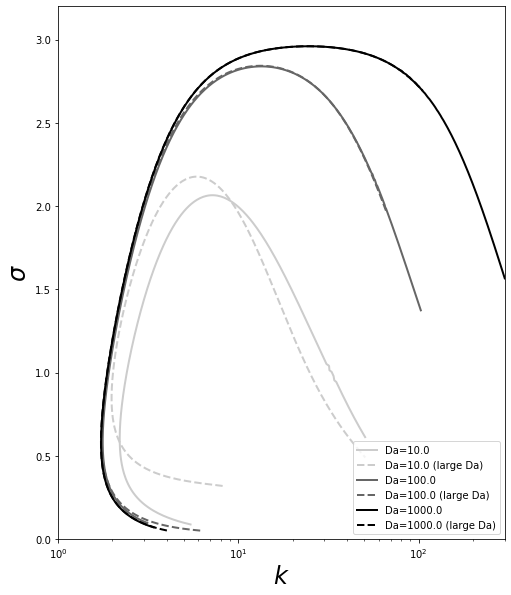

In [17]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

for vals, gray in zip([10., 100., 1000.], [0.8, 0.4, 0.0]):
    plt.plot(DC_cube[vals].k, DC_cube[vals].s, '-', linewidth=2, 
             color=[gray, gray, gray], label=r'Da='+str(vals))
    plt.plot(DC_quad[vals].k, DC_quad[vals].s, '--', linewidth=2, 
             color=[gray, gray, gray], label=r'Da=' + str(vals) + ' (large Da)')

plt.xscale('log')
plt.xlim(1, 300)
plt.xlabel(r'$k$', fontsize=24)
plt.ylim(0, 3.2)
plt.ylabel(r'$\sigma$', fontsize=24)
plt.legend()
plt.show()

### A modified problem and its analytical solution

It is possible to obtain an algebraic equation that can be solved for the growth-rate $\sigma$ as a function of wavenumber $k$ and parameters $\permexp,\Da,\Pe,\stiff$ (recall that $\Kk = 1 + k^2/(\Da\Pe)$). Without any approximations, the growth rate of $l=1$ perturbations is given by

\begin{multline}
  \label{eq:rxflow-analytical-sigma-full}
  \sigma = \pm\frac{\permexp}{\Kk}\left\{\left[ 
      \wavenumber^4\left(1 - \frac{\pi^2}{\Da^4\stiff^2\Kk^2} - 
        \frac{3}{\Da\stiff}\right) -
      \frac{\wavenumber^6}{\Da^3\stiff\Kk^2} -
      \wavenumber^2\left(\frac{\Kk^2}{\stiff^2} +
        \frac{2\pi^2}{\Da^2\stiff^2}\right) - 
      \frac{\pi^2\Kk^2}{\stiff^2}\right]^{1/2}\right. \\ 
  \left. \pm \left(\wavenumber^2 + \frac{2\pi^2 + k^2}{\Da\stiff}\right)\right\} 
  \left[2\left(\pi^2 + k^2\right) + 
    \frac{k^4}{2\Da^2\Kk^2}\right]^{-1}.
\end{multline}

The function `ReactiveFlowAnalyticalSolution` below takes $k, \permexp,\Da,\Pe,\stiff$ as arguments and evaluates the value of $\sigma$ given by equation \eqref{eq:rxflow-analytical-sigma-full}.

In [18]:
class PAR:
    def __init__(self):
        self.s = None
        self.k = None
        self.smax = None
        self.kmax = None
        self.X = None
        self.Y = None
        self.P = None
        self.phi = None
        self.U = None
        self.W = None

        
def ReactiveFlowAnalyticalSolution(k, n, Da, Pe, S):
    K = (1 + k**2 / Da / Pe).astype(np.clongdouble)
    b = np.pi
    # growth rate - upper branch
    full = np.zeros((k.shape[0], 2), dtype=np.clongdouble)
    b2 = b ** 2
    Da2 = Da ** 2
    Da3 = Da ** 3
    Da4 = Da ** 4
    K2 = K ** 2
    K4 = K ** 4
    k2 = k ** 2
    k4 = k ** 4
    k6 = k ** 6
    S2 = S ** 2
    full[:, 0] = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                    - 3.0 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                  + 4 * Da * K * b2 * n + Da * K * k2 * n + 2 * Da2 * K * S * k2 * n) / (
            4 * S * Da2 * K2 * b2 + 4 * S * Da2 * K2 * k2 + S * k4)
    # lower branch
    full[:, 1] = -(2.0 * n * np.sqrt(- Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4
                                     - 3 * Da3 * K2 * S * k4 - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4)
                   - K * (4 * Da * n * b2 + n * (2 * S * Da2 + Da) * k2)) / (
            S * (4 * Da2 * K2 * b2 + 4 * Da2 * K2 * k2 + k4))

    real1 = np.nonzero(np.imag(full[:, 0]).astype(np.float32) == 0.0)
    real2 = np.nonzero(np.imag(full[:, 1]).astype(np.float32) == 0.0)
    s = PAR()
    s.s = np.real(np.concatenate((np.flipud(full[real1, 0].flatten()), full[real2, 1].flatten())))
    s.k = np.real(np.concatenate((np.flipud(k[real1].flatten()), k[real2].flatten())))
    I = np.argmax(s.s)
    s.smax = s.s[I]
    s.kmax = s.k[I]

    # eigenfunctions
    K = 1 + s.kmax ** 2 / Da / Pe
    a = 0.5 * (n * K / S + s.smax * s.kmax ** 2 / Da) / (s.smax * K - n / Da / S)
    m = a + 1j * np.pi
    lambda_ = 2 * np.pi / s.kmax
    x = np.linspace(0, 2 * lambda_, 1000)
    hx = x[2]-x[1]
    y = np.linspace(0, 1, 1000)
    hy = y[2]-y[1]
    s.X, s.Y = np.meshgrid(x, y)
    s.P = np.exp(a * s.Y) * np.sin(np.pi * s.Y) * np.sin(s.kmax * s.X)
    tmp = np.exp(a * s.Y) * np.cos(np.pi * s.Y) * np.sin(s.kmax * s.X)
    dphi_dy = S * ((a ** 2 - np.pi ** 2 - s.kmax ** 2) * s.P + 2 * a * np.pi * tmp) / n
    s.phi = np.cumsum(dphi_dy, axis=0) * hy

    Px, Py = np.gradient(s.P, hx, hy)
    s.U = -S * Px
    s.W = (n - 1) * s.phi - S * Py

    s.P = (s.P - np.amin(s.P)) / (np.amax(s.P) - np.amin(s.P))
    s.phi = (s.phi - np.amin(s.phi)) / (np.amax(s.phi) - np.amin(s.phi))
    
    return s

In [19]:
n = 3.
Da = 1000.
Pe = 100.
S = np.asarray([0.01, 0.1, 1, 10]).astype(np.clongdouble)
k = np.logspace(-1.0, 4.0, 10000).astype(np.clongdouble)
s = []

for s_ in S:
    s.append(ReactiveFlowAnalyticalSolution(k, n, Da, Pe, s_))

Figure below plot the results for the modified problem with $\cmppres\first=0$ at $z=1$. __(a)__ Dispersion curves for $n=3$, $\Da=1000$, $\Pe=100$ and four values of $\stiff$. Maximum values of the growth rate for each curve are marked by stars. The eigenfunctions for each of these maxima are plotted in subsequent panels. __(b)__ The $\cmppres\first$ eigenfunction for $\stiff=1$. White curves are streamlines of the flow $\vel\liq = \zhat + \smallpar\vel\first$, with $\smallpar$ chosen to be $3\times10^{-3}$. __(c)__ $\cmppres\first$ for $\stiff=0.1$ with superimposed contours of the porosity perturbation $\por\first$. Porosity is larger in the low-pressure channels. __(d)__ $\cmppres\first$ for $\stiff=0.01$.

/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


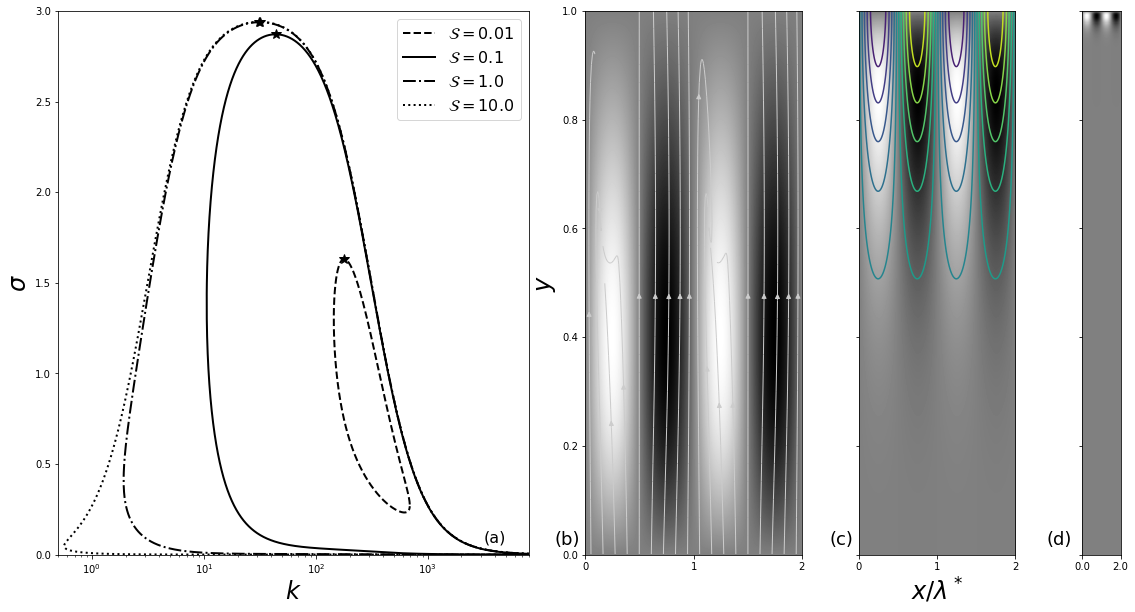

In [20]:
zoom = 2.0
fig = plt.figure(figsize=(zoom*9.7, zoom*5.0))
gs = gridspec.GridSpec(1, 4, width_ratios=[6, 3, 2, 1])

ax0 = plt.subplot(gs[0])
for s_, lstyi, S_ in zip(s, {'--k', '-k', '-.k', ':k'}, S):
    ax0.semilogx(s_.k, s_.s, lstyi, linewidth=2, 
                 label=r'$\mathcal{S}=' + str(np.real(S_).astype(np.float32)) + '$')
    ax0.plot(s_.kmax, s_.smax, '*k', linewidth=1, markersize=10)
ax0.set_xlabel(r'$k$', fontsize=24)
ax0.set_xlim(0.5, 8000)
ax0.set_xticks(ticks=(1.e0, 1.e1, 1.e2, 1.e3))
ax0.set_ylabel(r'$\sigma$', fontsize=24)
ax0.set_ylim(0.0, 3.0)
ax0.legend(fontsize=16)
ax0.text(0.5e4, 0.05, '(a)', fontsize=16, verticalalignment='bottom', horizontalalignment='right')

AR = 2 * np.pi / np.asarray([s[2].kmax, s[1].kmax, s[0].kmax])

ax1 = plt.subplot(gs[1])
lambda_ = np.float32(AR[0])
ax1 = plt.subplot(gs[1])
ax1.imshow(np.real(s[2].P).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax1.set_ylabel(r'$y$', fontsize=24)
nlines = 18
h = 2 * lambda_ / (nlines + 1)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5 * h, 2.0 * lambda_ - 0.5 * h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
epsilon = 3e-3
U = epsilon * np.real(s[2].U).astype(np.float64)
W = 1.0 + epsilon * np.real(s[2].W).astype(np.float64)
x = np.linspace(0, 2 * lambda_, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
ax1.streamplot(X, Y, U, W, start_points=seed,
               integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
ax1.set_xticks((0, AR[0], 2*AR[0]))
ax1.set_xticklabels((0, 1, 2))
ax1.text(-0.01, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

ax2 = plt.subplot(gs[2])
lambda_ = np.float32(AR[1])
ax2 = plt.subplot(gs[2])
ax2.imshow(np.flipud(np.real(s[1].P)).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
x = np.linspace(0, 2 * lambda_, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
ax2.contour(X, Y, np.real(s[1].phi).astype(np.float32), levels=np.linspace(0, 1, 12))
ax2.set_xticks((0, lambda_, 2*lambda_))
ax2.set_xticklabels((0, 1, 2))
ax2.set_yticklabels(())
ax2.set_xlabel(r'$x/\lambda^*$', fontsize=24)
ax2.text(-0.01, 0.01, r'(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

ax3 = plt.subplot(gs[3])
lambda_ = np.float32(AR[2])
ax3.imshow(np.flipud(np.real(s[0].P)).astype(np.float32), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
ax3.set_xticks((0, 2*lambda_))
ax3.set_xticklabels((0., 2.))
ax3.set_yticklabels(())
plt.text(-0.02, 0.01, r'(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.show()

Equation \eqref{eq:rxflow-analytical-sigma-full} is exact but difficult to analyse. We therefore design an approximation to be valid only near the peak growth rate:

\begin{equation}
  \label{eq:rxflow-asymptotic-sigma}
  \sigma\sim\permexp(1-\epsilon),\quad\epsilon \ll 1
\end{equation}

and substitute, dropping the $\permexp/\Da\stiff$ terms. We find that

\begin{align}
    \label{eq:rxflow-analytic-real-im-asymptotic_a}
    a &\sim \frac{1}{2\stiff} + \frac{\wavenumber^2}{2\Da}, \\
    \label{eq:rxflow-analytic-real-im-asymptotic_e}
    \epsilon & \sim \frac{a^2 + b^2}{\wavenumber^2} + \frac{\wavenumber^2}{\Da\Pe}.
\end{align}

Here we have made the additional approximation that near the maximum growth rate (i.e., for $\wavenumber\approx\wavenumber^*$ at which $\epsilon \ll 1$), $\wavenumber^2/\Da\Pe \ll 1$ and hence that $\Kk \sim 1$.

The maximum growth rate $\sigma\sim\sigma^*$ occurs where $\epsilon$ is at a minimum with respect to $\wavenumber$.  Using equations \eqref{eq:rxflow-analytic-real-im-asymptotic_a} - \eqref{eq:rxflow-analytic-real-im-asymptotic_e} we find that

\begin{equation}
  \label{eq:rxflow-kstar-full}
  \wavenumber^* \sim \left(\frac{4\Da\Pe\mathcal{B}}
    {4+\Pe/\Da}\right)^{1/4},
\end{equation}

where $\mathcal{B} \equiv b^2 + (2\stiff)^{-2}$. The maximum growth rate $\sigma^*$ of the channel instability is 

\begin{equation}
  \label{eq:rxflow-sstar-full}
  \sigma^* \sim \permexp\left[1 - 
    2\sqrt{\frac{\mathcal{B}(4+\Pe/\Da)}{\Da\Pe}}\right].
\end{equation}


In [21]:
class SA_Growth():
    def __init__(self):
        self.k = None
        self.a = None
        self.e = None
        self.s = None


def asym_maxgrowth(k, n, Da, Pe, S, l):
    b = l * np.pi
    B = b**2 + 1.0/4.0/S**2
    s_ = SA_Growth()
    k = np.power(4.0*Da*Pe*(b**2 + 1.0/4.0/S**2)/(4.0 + Pe/Da), 0.25)
    a = 1.0/2.0/S + k**2.0/2.0/Da
    e = (a**2 + b**2)/k**2 + k**2/Da/Pe
    s = n*(1.0 - 1.0/Da/2.0/S - 2.0*np.sqrt(B*(1.0/Da/Pe + 1.0/4.0/Da**2)))
    s_.k = np.real(k).astype(np.float32)
    s_.a = np.real(a).astype(np.float32)
    s_.e = np.real(e).astype(np.float32)
    s_.s = np.real(s).astype(np.float32)
    return s_

In [22]:
class SA_Dispersion():
    def __init__(self):
        self.s = None
        self.k = None


def asym_dispersion(k, n, Da, Pe, S, l):
    a = 1/2/S + k**2/2/Da
    b = l * np.pi
    epsilon = (a**2 + b**2)/k**2 + k**2/Da/Pe
    s = n*(1-epsilon)
    s[np.imag(s) != 0.0] = np.nan
    return np.real(s).astype(np.float32)


def full_dispersion(k, n, Da, Pe, S, l):
    b = np.clongdouble(l * np.pi)
    b2 = b ** 2
    k2 = k**2
    k4 = k2 * k2
    k6 = k2 * k4
    Da = np.clongdouble(Da)
    Da2 = Da ** 2
    Da3 = Da * Da2
    Da4 = Da2 * Da2
    K = 1.0 + k2 / Da / np.clongdouble(Pe)
    K2 = K ** 2
    K4 = K2 * K2
    S2 = np.clongdouble(S ** 2)

    # upper branch
    su = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                            - 2.0 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4) + 4.0 * Da * K * b2 * n
          + Da * K * k2 * n + 2.0 * Da2 * K * S * k2 * n) / (4.0 * S * Da2 * K2 * b2 + 4.0 * S * Da2 * K2 * k2 + S * k4)
    iu = np.imag(su) == 0.0
    # lower branch
    sl = -(2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                             - 2.0 * Da2 * K2 * b2 * k2 - Da*S*k6 - b2 * k4)
           - K*(4 * Da * n * b2 + n * (2.0 * S * Da2 + Da) * k2)) / (S*(4 * Da2 * K2 * b2 + 4.0 * Da2 * K2 * k2 + k4))
    il = np.imag(sl) == 0
    s = SA_Dispersion()
    s.s = np.hstack([np.flip(np.real(su[iu]).astype(np.float32)), np.real(sl[il]).astype(np.float32)])
    s.k = np.hstack([np.flip(np.real(k[iu]).astype(np.float32)), np.real(k[il]).astype(np.float32)])
    return s

Properties of the dispersion curve near its maximum, with $n=3,\,\Da=10^4,\,b=\pi$. __(a)__ Comparison of the exact dispersion relation \eqref{eq:rxflow-analytical-sigma-full} (solid lines) with the asymptotic relations \eqref{eq:rxflow-asymptotic-sigma}-\eqref{eq:rxflow-analytic-real-im-asymptotic_e} (dashed lines) for $\Pe/\Da=10^{-2}$ and two values of $\stiff$, as given in the legend. __(b)__ Contours of fastest-growing (non-dimensional) wavelength $\lambda^*$ for a range of $\stiff$ and $\Pe$ from equation \eqref{eq:rxflow-kstar-full}. Dotted lines are at $\Pe/\Da = 4$ and $\stiff = 1/2\pi$. In both panels, stars indicate the maximum ($\wavenumber^*,\sigma^*$) of the asymptotic curves, computed with \eqref{eq:rxflow-kstar-full} and \eqref{eq:rxflow-sstar-full}.

/Users/fredericoteixeira/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


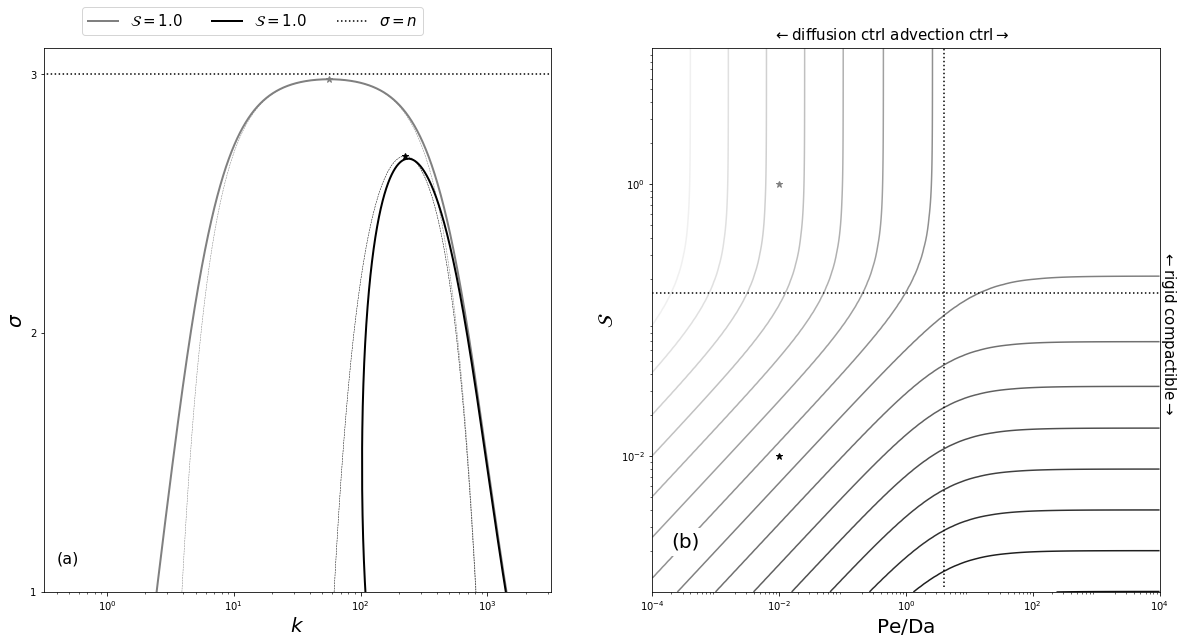

In [23]:
zoom = 2.0
fig = plt.figure(figsize=(10*zoom, 5*zoom))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax0 = plt.subplot(gs[0])

Da = 1e4
k = np.logspace(-1, 4, 10000).astype(np.clongdouble)
n = 3
Pe = Da / 100
S = np.asarray([1.0, 0.01]).astype(np.clongdouble)
l = 1.0

sfull = full_dispersion(k, n, Da, Pe, S[0], l)
sasym = asym_dispersion(k, n, Da, Pe, S[0], l)
smax = asym_maxgrowth(k, n, Da, Pe, S[0], l)
ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, color=[0.5, 0.5, 0.5],
           label=r'$\mathcal{S}='+str(np.real(S[0]))+'$')
ax0.loglog(k, sasym, '--k', linewidth=0.5, color=[0.5, 0.5, 0.5])
ax0.plot(smax.k, smax.s, '*k', markersize=7, color=[0.5, 0.5, 0.5])

sfull = full_dispersion(k, n, Da, Pe, S[1], l)
sasym = asym_dispersion(k, n, Da, Pe, S[1], l)
smax = asym_maxgrowth(k, n, Da, Pe, S[1], l)
ax0.loglog(sfull.k, sfull.s, '-k', linewidth=2, label=r'$\mathcal{S}='+str(np.real(S[0]))+'$')
ax0.loglog(k, sasym, '--k', linewidth=0.5)
ax0.plot(smax.k, smax.s, '*k', markersize=7)

ax0.plot([k[0], k[-1]], [n, n], ':k', label=r'$\sigma=n$')

ax0.set_xlim(np.sqrt(0.1), np.power(10, 3.5))
ax0.set_xticks([1.e0, 1.e1, 1.e2, 1.e3])
ax0.set_xlabel(r'$k$', fontsize=20)

ax0.set_ylabel(r'$\sigma$', fontsize=20)
ax0.set_ylim(1.0, 3.1)
ax0.set_yscale('linear')
ax0.set_yticks([1, 2, 3])

ax0.text(0.4, 1.1, r'(a)', fontsize=16, verticalalignment='bottom', horizontalalignment='left')

ax0.legend(fontsize=15, loc='upper left', bbox_to_anchor=(0.06, 1.09), ncol=3)

ax1 = plt.subplot(gs[1])

Spts = S
Pe_Da = Pe / Da

Pe = np.logspace(np.log10(Da) - 4.0, np.log10(Da) + 4, 100)
S = np.logspace(-3.0, 1.0, 100)
X, Y = np.meshgrid(Pe, S)
B = np.pi ** 2 + 1. / (2 * Y) ** 2
Ks = np.power(4 * Da * X * B / (4 + X / Da), 0.25)
lambda_ = 2 * np.pi / Ks

ax1.contour(Pe / Da, S, np.log10(lambda_), 16, cmap='gray')
ax1.plot([Pe[0]/Da, Pe[-1]/Da], [1/2/np.pi, 1/2/np.pi], ':k')
ax1.plot([4, 4], [S[1], S[-1]], ':k')
ax1.plot(Pe_Da, Spts[0], '*k', markersize=7, color=[0.5, 0.5, 0.5])
ax1.plot(Pe_Da, Spts[1], '*k', markersize=7)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks((1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4))
ax1.set_yticks((1.e-2, 1.e0))
ax1.set_ylabel(r'$\mathcal{S}$', fontsize=20)
ax1.set_xlabel(r'Pe$/$Da', fontsize=20)
ax1.text(0.0002, 0.002, r'(b)', fontsize=20, verticalalignment='bottom',
         horizontalalignment='left', backgroundcolor='w')
ax1.text(1.4e4, 0.02, r'$\leftarrow$rigid compactible$\rightarrow$', rotation=-90, horizontalalignment='center',
         verticalalignment='bottom', fontsize=15)
ax1.text(0.58, 11, r'$\leftarrow$diffusion ctrl advection ctrl$\rightarrow$', horizontalalignment='center',
         verticalalignment='bottom', fontsize=15)

plt.show()

## Application to the mantle

Parameters and their values (and ranges) for application to the mantle beneath mid-ocean ridges:


| Variable (unit) | Symbol | Estimate (range) |
| --- | --- | --- | 
| Permeability exponent | $\permexp$ | $3$ $(2-3)$ |
| Solubility gradient (m$^{-1}$)  | $\beta$ | $2\times10^{-6}$ ($10^{-6}-4\times10^{-6}$) |
| Compositional offset | $\alpha$ | $1$ |
| Melting region depth (m) | $H$ | $8\times10^{4}$ |
| Compaction length (m) | $\cmplength$ | $10^{3}$  ($3\times10^2-10^4$) |
| Melt flux  (m s$^{-1}$)  | $\por_0 w_0$ | $3\times10^{-11}$ ($5\times10^{-12}-2\times10^{-10}$) |
| Diffusivity (m$^2$s$^{-1}$) | $\por_0 \chemdiffuse$ | $3\times10^{-14}$ ($10^{-15}-10^{-12}$) |
| Reaction rate (s$^{-1}$) | $\rxnrate$ | $3\times10^{-8}$ ($10^{-11}-10^{-4}$) |
| Decompression melting rate (s$^{-1}$) | $W_0\adiprod$ | $3\times10^{-15}$ ($10^{-15} - 10^{-14}$) |
| Melt productivity~ratio | $\dpro$ | $45$ ($1-200$)  |
| Reactive melt volume | $\rpro$ |  $0.14$ ($0.07-0.28$) |
| Peclet number | $\Pe$ | $7\times10^9$ ($3.5\times10^7 - 1.4\times10^{12}$) |
| Damköhler number | $\Da$ | $7 \times 10^7$ ($3.5\times10^3 - 1.4\times10^{12}$) |
| Stiffness number | $\stiff$ | $3\times10^{-5}$ ($1\times10^{-6} - 6\times10^{-3}$) | 

In [24]:
class PAR:
    def __init__(self):
        self.n = 3  # permeability exponent
        self.S = 3e-5  # rigidity parameter
        self.Da = 7e7  # Damkohler number
        self.Pe = 7e9  # Peclet number
        self.H = 8e4  # column height, metres
        self.tscale = 1 * 0.01 / 3e-11 / 2e-6 / (np.pi * 1e7)  # years


def Dispersion(k, n, Da, Pe, S):
    k = k.astype(np.clongdouble)
    k2 = k * k
    k4 = k2 * k2
    k6 = k4 * k2
    n, Da, Pe, S = np.clongdouble([n, Da, Pe, S])
    K = 1 + k ** 2 / Da / Pe
    K2 = K * K
    K4 = K2 * K2
    Da2 = Da * Da
    Da3 = Da2 * Da
    Da4 = Da2 * Da2
    b = np.clongdouble(np.pi)
    b2 = b * b
    S2 = S * S
    # upper branch
    s = (2.0 * n * np.sqrt(-Da4 * K4 * b2 - Da4 * K4 * k2 + Da4 * K2 * S2 * k4 - 3.0 * Da3 * K2 * S * k4
                           - 2 * Da2 * K2 * b2 * k2 - Da * S * k6 - b2 * k4) + 4.0 * Da * K * b2 * n + Da * K * k2 * n
         + 2 * Da2 * K * S * k2 * n) / (4 * S * Da2 * K2 * b2 + 4.0 * S * Da2 * K2 * k2 + S * k4)
    s[np.imag(s) != 0.0] = np.nan
    return np.real(s).astype(np.float32)

Figure below plots the time-scale of channel growth $1/\sigma$ as a function of the horizontal wavelength of channels.  This curve is computed using the full dispersion relation \eqref{eq:rxflow-analytical-sigma-full} with preferred parameter values from table above. Horizontal dotted lines mark the minimum growth time ($\sigma=1/\permexp$, in non-dimensional terms) and this value plus 2\%.

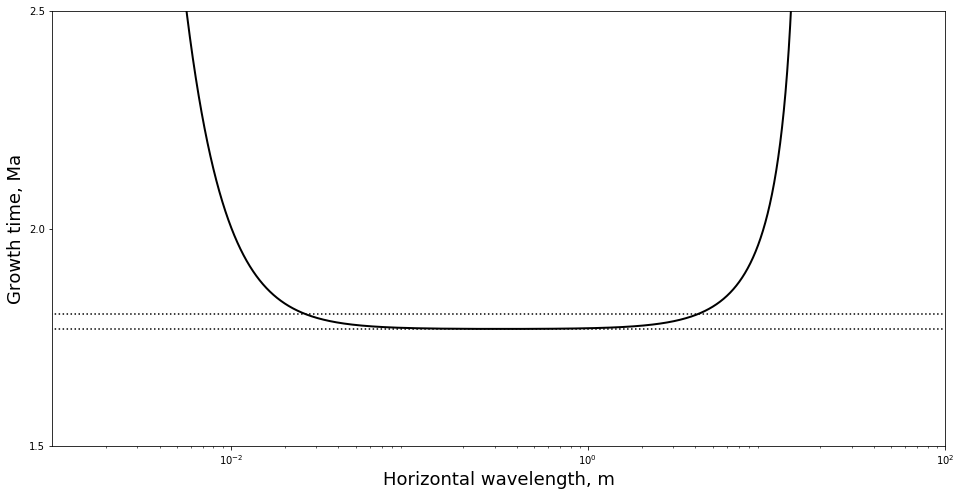

In [25]:
zoom = 2.0
fig = plt.figure(figsize=(8*zoom, 4*zoom))

par = PAR()
k = np.logspace(4, 8, 10000)
s = Dispersion(k, par.n, par.Da, par.Pe, par.S)

lambda_ = (2 * np.pi / k) * par.H  # metres
tau = (1. / s) * par.tscale / 1e6  # million years
tau_ref = (1. / par.n) * par.tscale / 1e6  # million years
tau_ref90 = (1.02 / par.n) * par.tscale / 1e6  # million years

plt.semilogx(lambda_, tau, '-k', linewidth=2)
plt.plot([1e-5, 1e5], [tau_ref, tau_ref], ':k')
plt.plot([1e-5, 1e5], [tau_ref90, tau_ref90], ':k')
plt.xlim(1e-3, 1e2)
plt.ylim(1.5, 2.5)
plt.xticks((1e-2, 1e0, 1e2))
plt.yticks((1.5, 2.0, 2.5))
plt.xlabel('Horizontal wavelength, m', fontsize=18)
plt.ylabel('Growth time, Ma', fontsize=18)

plt.show()